In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', None)    # None means no limit
pd.set_option('display.max_columns', None)    # None means no limit
from functions_variables import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.dates as mdates


In [2]:
# Load data
df = pd.read_csv('../data/preprocessed/macro_finance_data_2014_2023.csv')
df.tail()

Date  WTI Price  Natural Gas Price  Aluminum Price  Copper Price  \
3221  2024-02-19      78.11              1.558          2197.0        3.8110   
3222  2024-02-20      78.18              1.576          2193.5        3.8675   
3223  2024-02-21      77.91              1.773          2219.5        3.8750   
3224  2024-02-22      78.61              1.732          2198.0        3.8970   
3225  2024-02-23      76.49              1.603          2180.0        3.8800   

      Gold Price  Platinum Price  Silver Price  Lumber Price  Interest_Rate  \
3221      2027.5          905.65        23.003         565.0            5.0   
3222      2039.8          914.30        23.136         556.5            5.0   
3223      2034.3          889.60        22.874         560.5            5.0   
3224      2030.7          905.50        22.784         564.5            5.0   
3225      2049.4          909.60        22.982         564.5            5.0   

            GDP    CPI    HPI  Trade Balance  Unemployment  Wholesale Trade  \
3221  2215040.0  158.3  124.3        62379.9           6.1      117287179.0   
3222  2215040.0  158.3  124.3        62379.9           6.1      117287179.0   
3223  2215040.0  158.3  124.3        62379.9           6.1      117287179.0   
3224  2215040.0  158.3  124.3        62379.9           6.1      117287179.0   
3225  2215040.0  158.3  124.3        62379.9           6.1      117287179.0   

            US_GDP  Housing starts       DAX  STOXX 50  FTSE 100    NASDAQ  \
3221  2.795700e+13         62696.0  17092.26   4763.07   7728.50  15775.65   
3222  2.795700e+13         62696.0  17068.43   4760.28   7719.21  15630.78   
3223  2.795700e+13         62696.0  17118.12   4775.31   7662.51  15580.87   
3224  2.795700e+13         62696.0  17370.45   4855.36   7684.49  16041.62   
3225  2.795700e+13         62696.0  17419.33   4872.57   7706.28  15996.82   

      Nikkei 225  Russell 2000  S&P 500       TSX  CADJPY  EURCAD  GBPCAD  \
3221    38470.38       2032.74  5005.57  21255.61  111.27  1.4536  1.6985   
3222    38363.61       2004.14  4975.51  21217.53  110.89  1.4606  1.7060   
3223    38262.16       1994.74  4981.80  21172.38  111.27  1.4608  1.7062   
3224    39098.68       2013.84  5087.03  21318.08  111.64  1.4590  1.7066   
3225    39098.68       2016.69  5088.80  21413.15  111.42  1.4610  1.7112   

      USDCAD  10 YR Bond Yield  
3221  1.3488               3.1  
3222  1.3520               3.1  
3223  1.3505               3.1  
3224  1.3481               3.1  
3225  1.3505               3.1

### Create Target Variable for TSX Index if Index has Increased from the Prior Day

In [3]:
df['Index Up'] = df['TSX'] > df['TSX'].shift(1)
df.head(10)

Date  WTI Price  Natural Gas Price  Aluminum Price  Copper Price  \
0  2014-01-01      98.70              4.232         1840.25        3.3815   
1  2014-01-02      95.44              4.321         1840.25        3.3815   
2  2014-01-03      93.96              4.304         1840.25        3.3550   
3  2014-01-04      93.96              4.304         1840.25        3.3550   
4  2014-01-05      93.96              4.304         1840.25        3.3550   
5  2014-01-06      93.43              4.306         1840.25        3.3595   
6  2014-01-07      93.67              4.299         1840.25        3.3595   
7  2014-01-08      92.33              4.216         1840.25        3.3425   
8  2014-01-09      91.66              4.005         1840.25        3.2990   
9  2014-01-10      92.72              4.053         1840.25        3.3415   

   Gold Price  Platinum Price  Silver Price  Lumber Price  Interest_Rate  \
0      1225.2         1377.05        20.128         353.3            1.0   
1      1225.2         1402.30        20.128         353.3            1.0   
2      1238.6         1412.45        20.211         356.8            1.0   
3      1238.6         1412.45        20.211         356.8            1.0   
4      1238.6         1407.30        20.211         356.8            1.0   
5      1238.0         1415.60        20.103         352.0            1.0   
6      1229.6         1413.65        19.787         354.2            1.0   
7      1225.5         1416.65        19.539         356.0            1.0   
8      1229.4         1418.90        19.683         365.5            1.0   
9      1246.9         1437.35        20.223         362.2            1.0   

         GDP    CPI   HPI  Trade Balance  Unemployment  Wholesale Trade  \
0  1863035.0  123.1  94.1        41334.2           7.7       50184932.0   
1  1863035.0  123.1  94.1        41334.2           7.7       50184932.0   
2  1863035.0  123.1  94.1        41334.2           7.7       50184932.0   
3  1863035.0  123.1  94.1        41334.2           7.7       50184932.0   
4  1863035.0  123.1  94.1        41334.2           7.7       50184932.0   
5  1863035.0  123.1  94.1        41334.2           7.7       50184932.0   
6  1863035.0  123.1  94.1        41334.2           7.7       50184932.0   
7  1863035.0  123.1  94.1        41334.2           7.7       50184932.0   
8  1863035.0  123.1  94.1        41334.2           7.7       50184932.0   
9  1863035.0  123.1  94.1        41334.2           7.7       50184932.0   

         US_GDP  Housing starts      DAX  STOXX 50  FTSE 100   NASDAQ  \
0  1.719202e+13         33923.0  9400.04   3059.93   6717.91  4143.07   
1  1.719202e+13         33923.0  9400.04   3059.93   6717.91  4143.07   
2  1.719202e+13         33923.0  9435.15   3074.43   6730.67  4131.91   
3  1.719202e+13         33923.0  9435.15   3074.43   6730.67  4131.91   
4  1.719202e+13         33923.0  9435.15   3074.43   6730.67  4131.91   
5  1.719202e+13         33923.0  9428.00   3069.16   6730.73  4113.68   
6  1.719202e+13         33923.0  9506.20   3110.96   6755.45  4153.18   
7  1.719202e+13         33923.0  9497.84   3110.66   6721.78  4165.61   
8  1.719202e+13         33923.0  9421.61   3090.26   6691.34  4156.19   
9  1.719202e+13         33923.0  9473.24   3104.15   6739.94  4174.66   

   Nikkei 225  Russell 2000  S&P 500       TSX  CADJPY  EURCAD  GBPCAD  \
0    15908.88       1150.72  1831.98  13594.19   98.88  1.4640  1.7634   
1    15908.88       1150.72  1831.98  13594.19   98.18  1.4589  1.7558   
2    15908.88       1156.09  1831.37  13548.86   98.59  1.4452  1.7460   
3    15908.88       1156.09  1831.37  13548.86   98.59  1.4452  1.7460   
4    15908.88       1156.09  1831.37  13548.86   98.59  1.4452  1.7460   
5    15908.88       1147.16  1826.77  13495.54   97.81  1.4522  1.7481   
6    15814.37       1157.63  1837.88  13596.93   97.18  1.4658  1.7658   
7    16121.45       1157.46  1837.49  13614.63   96.91  1.4688  1.7795   
8    15880.33       1158.35 

## For EDA set the date as the index to leverage time series specific methods for understanding the data

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [5]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['DayofWeek'] = df.index.dayofweek
df.tail()

WTI Price  Natural Gas Price  Aluminum Price  Copper Price  \
Date                                                                     
2024-02-19      78.11              1.558          2197.0        3.8110   
2024-02-20      78.18              1.576          2193.5        3.8675   
2024-02-21      77.91              1.773          2219.5        3.8750   
2024-02-22      78.61              1.732          2198.0        3.8970   
2024-02-23      76.49              1.603          2180.0        3.8800   

            Gold Price  Platinum Price  Silver Price  Lumber Price  \
Date                                                                 
2024-02-19      2027.5          905.65        23.003         565.0   
2024-02-20      2039.8          914.30        23.136         556.5   
2024-02-21      2034.3          889.60        22.874         560.5   
2024-02-22      2030.7          905.50        22.784         564.5   
2024-02-23      2049.4          909.60        22.982         564.5   

            Interest_Rate        GDP    CPI    HPI  Trade Balance  \
Date                                                                
2024-02-19            5.0  2215040.0  158.3  124.3        62379.9   
2024-02-20            5.0  2215040.0  158.3  124.3        62379.9   
2024-02-21            5.0  2215040.0  158.3  124.3        62379.9   
2024-02-22            5.0  2215040.0  158.3  124.3        62379.9   
2024-02-23            5.0  2215040.0  158.3  124.3        62379.9   

            Unemployment  Wholesale Trade        US_GDP  Housing starts  \
Date                                                                      
2024-02-19           6.1      117287179.0  2.795700e+13         62696.0   
2024-02-20           6.1      117287179.0  2.795700e+13         62696.0   
2024-02-21           6.1      117287179.0  2.795700e+13         62696.0   
2024-02-22           6.1      117287179.0  2.795700e+13         62696.0   
2024-02-23           6.1      117287179.0  2.795700e+13         62696.0   

                 DAX  STOXX 50  FTSE 100    NASDAQ  Nikkei 225  Russell 2000  \
Date                                                                           
2024-02-19  17092.26   4763.07   7728.50  15775.65    38470.38       2032.74   
2024-02-20  17068.43   4760.28   7719.21  15630.78    38363.61       2004.14   
2024-02-21  17118.12   4775.31   7662.51  15580.87    38262.16       1994.74   
2024-02-22  17370.45   4855.36   7684.49  16041.62    39098.68       2013.84   
2024-02-23  17419.33   4872.57   7706.28  15996.82    39098.68       2016.69   

            S&P 500       TSX  CADJPY  EURCAD  GBPCAD  USDCAD  \
Date                                                            
2024-02-19  5005.57  21255.61  111.27  1.4536  1.6985  1.3488   
2024-02-20  4975.51  21217.53  110.89  1.4606  1.7060  1.3520   
2024-02-21  4981.80  21172.38  111.27  1.4608  1.7062  1.3505   
2024-02-22  5087.03  21318.08  111.64  1.4590  1.7066  1.3481   
2024-02-23  5088.80  21413.15  111.42  1.4610  1.7112  1.3505   

            10 YR Bond Yield  Index Up  Year  Month  Day  DayofWeek  
Date                                                                 
2024-02-19               3.1     False  2024      2   19          0  
2024-02-20               3.1     False  2024      2   20          1  
2024-02-21               3.1     False  2024      2   21          2  
2024-02-22               3.1      True  2024      2   22          3  
2024-02-23               3.1      True  2024      2   23          4

In [6]:
# create a dataframe that only includes the weekdays
# commodities and currency are traded on weekend, but the index is only traded during the week, therefore the number of False values will be present 
# if the weekends are included and distort the percentage of index up calculations
df_weekdays = df[df['DayofWeek'] < 5]
df_weekdays.tail(30)

WTI Price  Natural Gas Price  Aluminum Price  Copper Price  \
Date                                                                     
2024-01-15      72.79              3.066          2204.5        3.7782   
2024-01-16      72.40              2.900          2214.0        3.7665   
2024-01-17      72.56              2.870          2178.0        3.7330   
2024-01-18      74.08              2.697          2163.5        3.7450   
2024-01-19      73.41              2.519          2166.0        3.7865   
2024-01-22      75.19              2.419          2159.0        3.7635   
2024-01-23      74.37              2.450          2228.0        3.7935   
2024-01-24      75.09              2.641          2229.5        3.8860   
2024-01-25      77.36              2.571          2238.5        3.8690   
2024-01-26      78.01              2.712          2274.5        3.8520   
2024-01-29      76.78              2.490          2264.5        3.8790   
2024-01-30      77.82              2.077          2274.5        3.9110   
2024-01-31      75.85              2.100          2280.0        3.9060   
2024-02-01      73.82              2.050          2247.0        3.8535   
2024-02-02      72.28              2.079          2233.5        3.8215   
2024-02-05      72.78              2.082          2212.5        3.7715   
2024-02-06      73.31              2.009          2230.5        3.7830   
2024-02-07      73.86              1.967          2222.0        3.7355   
2024-02-08      76.22              1.917          2221.5        3.7020   
2024-02-09      76.84              1.847          2216.0        3.6815   
2024-02-12      76.92              1.768          2227.0        3.7240   
2024-02-13      77.87              1.689          2225.5        3.7110   
2024-02-14      76.64              1.609          2235.5        3.7000   
2024-02-15      78.03              1.581          2224.5        3.7580   
2024-02-16      79.19              1.609          2218.0        3.8385   
2024-02-19      78.11              1.558          2197.0        3.8110   
2024-02-20      78.18              1.576          2193.5        3.8675   
2024-02-21      77.91              1.773          2219.5        3.8750   
2024-02-22      78.61              1.732          2198.0        3.8970   
2024-02-23      76.49              1.603          2180.0        3.8800   

            Gold Price  Platinum Price  Silver Price  Lumber Price  \
Date                                                                 
2024-01-15     2057.85          921.35        23.328         559.0   
2024-01-16     2039.70          904.40        22.983         554.5   
2024-01-17     2015.90          889.60        22.559         546.5   
2024-01-18     2031.10          912.00        22.699         547.5   
2024-01-19     2038.50          907.00        22.601         548.0   
2024-01-22     2031.50          903.00        22.183         551.5   
2024-01-23     2035.20          905.50        22.354         567.5   
2024-01-24     2025.40          914.90        22.769         565.5   
2024-01-25     2027.10          894.50        22.814         574.0   
2024-01-26     2026.60          921.30        22.758         575.5   
2024-01-29     2034.90          938.30        23.134         579.0   
2024-01-30     2050.90          931.70        23.225         569.5   
2024-01-31     2067.40          932.60        23.169         561.5   
2024-02-01     2071.10          922.30        23.236         555.5   
2024-02-02     2053.70          901.60        22.796         557.0   
2024-02-05     2042.90          903.50        22.422         553.5   
2024-02-06     2051.40          911.60        22.478         554.5   
2024-02-07     2051.70          886.90        22.360         554.0   
2024-02-08     2047.90          894.00        22.636         550.5   
2024-02-09     2038.70          878.20        22.594         552.5   
2024-02-12     2033.00          897.10        22.767         552.5   
2024-02-13     2007.20          8

In [7]:
#group index up by month
grouped = df_weekdays.groupby(['Year','Month'])['Index Up'].sum()
print(grouped)

Year  Month
2014  1        12
      2        14
      3        12
      4        12
      5        11
      6        17
      7        13
      8        12
      9         6
      10       10
      11       13
      12       11
2015  1        12
      2        12
      3        11
      4        14
      5         9
      6        11
      7        12
      8         8
      9        11
      10       11
      11        8
      12       11
2016  1         9
      2        10
      3        13
      4        11
      5        10
      6        11
      7        14
      8        13
      9        13
      10       10
      11       11
      12       15
2017  1        10
      2        11
      3        13
      4         9
      5        10
      6         9
      7         9
      8        10
      9        12
      10       14
      11       11
      12       12
2018  1        11
      2         8
      3        13
      4        13
      5        15
      6        13
      7        1

In [8]:
#calculate the number of trading days per month
trading_days = df_weekdays.groupby(['Year', 'Month']).size()

# Calculate the percentage of Index Up for each month relative to the total
percentage_index_up = (grouped / trading_days) * 100

# Combine the results into a DataFrame
result = pd.DataFrame({
    'Index Up Sum': grouped,
    'Total Trading Days': trading_days,
    'Percentage of Index Up': percentage_index_up
})
result

Index Up Sum  Total Trading Days  Percentage of Index Up
Year Month                                                          
2014 1                12                  23               52.173913
     2                14                  20               70.000000
     3                12                  21               57.142857
     4                12                  22               54.545455
     5                11                  22               50.000000
     6                17                  21               80.952381
     7                13                  23               56.521739
     8                12                  21               57.142857
     9                 6                  22               27.272727
     10               10                  23               43.478261
     11               13                  20               65.000000
     12               11                  23               47.826087
2015 1                12                  22               54.545455
     2                12                  20               60.000000
     3                11                  22               50.000000
     4                14                  22               63.636364
     5                 9                  21               42.857143
     6                11                  22               50.000000
     7                12                  23               52.173913
     8                 8                  21               38.095238
     9                11                  22               50.000000
     10               11                  22               50.000000
     11                8                  21               38.095238
     12               11                  23               47.826087
2016 1                 9                  21               42.857143
     2                10                  21               47.619048
     3                13                  23               56.521739
     4                11                  21               52.380952
     5                10                  22               45.454545
     6                11                  22               50.000000
     7                14                  21               66.666667
     8                13                  23               56.521739
     9                13                  22               59.090909
     10               10                  21               47.619048
     11               11                  22               50.000000
     12               15                  22               68.181818
2017 1                10                  22               45.454545
     2                11                  20               55.000000
     3                13                  23               56.521739
     4                 9                  20               45.000000
     5                10                  23               43.478261
     6                 9                  22               40.909091
     7                 9                  21               42.857143
     8                10                  23               43.478261
     9                12                  21               57.142857
     10               14                  22               63.636364
     11               11                  22               50.000000
     12               12                  21               57.142857
2018 1                11                  23               47.826087
     2                 8                  20               40.000000
     3                13                  22               59.090909
     4                13                  21               61.904762
     5                15                  23               65.217391
     6                13                  21               61.904762
     7                10                  22               45.454545
     8                12                  23               52.173913
     9    

In [9]:
result.describe()

Index Up Sum  Total Trading Days  Percentage of Index Up
count    122.000000          122.000000              122.000000
mean      11.483607           21.704918               52.965159
std        2.235083            1.049900               10.286229
min        6.000000           17.000000               27.272727
25%       10.000000           21.000000               45.454545
50%       11.000000           22.000000               52.380952
75%       13.000000           22.000000               59.090909
max       19.000000           23.000000               82.608696

In [10]:
# Calculate the average percentage of index up per trading day for each month for all 10 years combined
month_grouped = result.groupby('Month')['Percentage of Index Up'].mean()
month_grouped

Month
1     56.810054
2     54.676598
3     55.557124
4     56.690476
5     50.362319
6     55.740260
7     52.774327
8     48.572370
9     45.125541
10    50.227743
11    60.093074
12    48.396386
Name: Percentage of Index Up, dtype: float64

In [11]:
month_grouped.mean()

52.91885599610547

In [12]:
# Calculate the average percentage of index up per trading day for each year for all 10 years
year_grouped = result.groupby('Year')['Percentage of Index Up'].mean()
year_grouped

Year
2014    55.171356
2015    49.769120
2016    53.576134
2017    50.051760
2018    49.686147
2019    55.693739
2020    56.918800
2021    55.775849
2022    49.589843
2023    52.271943
2024    59.846547
Name: Percentage of Index Up, dtype: float64

In [13]:
year_grouped.mean()

53.48647609720616

In [14]:
# To determine if there are any specifc days on which the stock index goes up
day_grouped = df_weekdays.groupby('Day')['Index Up'].sum()
day_grouped.sort_values(ascending=False)

Day
15    59
20    52
14    52
4     51
8     50
12    50
16    49
29    48
10    48
17    48
18    47
2     47
5     47
25    46
28    46
11    46
6     45
3     45
26    45
7     45
19    44
24    44
23    43
13    42
9     42
21    42
27    42
22    41
1     40
30    37
31    18
Name: Index Up, dtype: int64

### Date-Time Components Conclusion
<p>The analysis didn't provide any meaningful patterns or trends involved. The index increased slightly more on a daily basis than going down at an average of 52.4% of the time. The maximum month where the index went up was 82.6% of the time in 2019 and the minimum was 2017 September at 27%. During the Covid Pandemic the market actually performed better in 2019-2021 with the index increasing greater than 55% of the time. Monthly fluctions occured, but on average each year the results are similar across all 10 years. It appears that the middle of the month has higher than normal times where the index went up, with the number of days being the highest for those days.</p>

## Time Series Graphing

In [78]:
column_list = df.columns[:-5]
column_list

Index(['WTI Price', 'Natural Gas Price', 'Aluminum Price', 'Copper Price',
       'Gold Price', 'Platinum Price', 'Silver Price', 'Lumber Price',
       'Interest_Rate', 'GDP', 'CPI', 'HPI', 'Trade Balance', 'Unemployment',
       'Wholesale Trade', 'US_GDP', 'Housing starts', 'DAX', 'STOXX 50',
       'FTSE 100', 'NASDAQ', 'Nikkei 225', 'Russell 2000', 'S&P 500', 'TSX',
       'CADJPY', 'EURCAD', 'GBPCAD', 'USDCAD', '10 YR Bond Yield'],
      dtype='object')

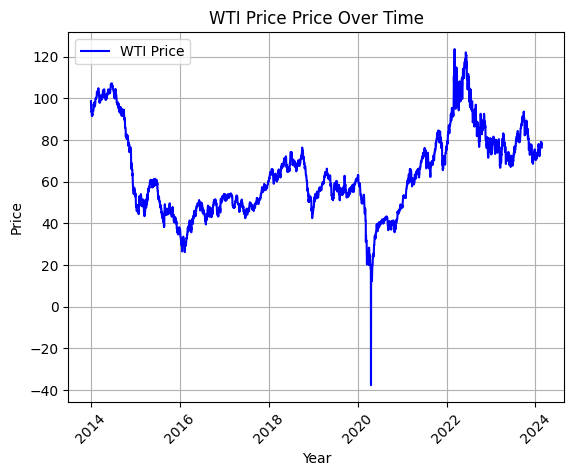

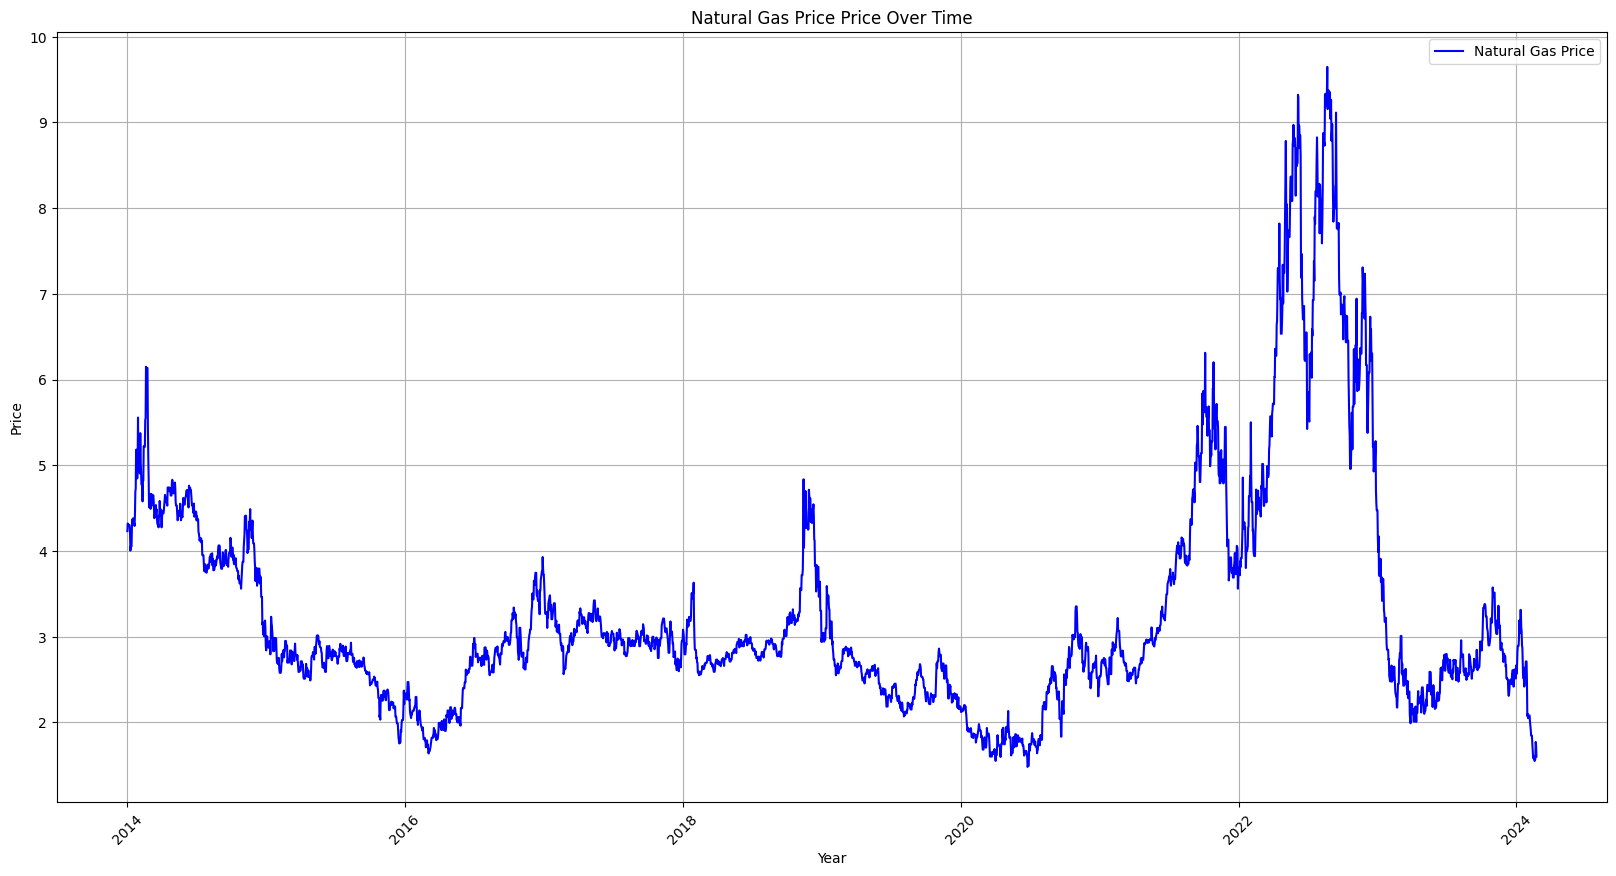

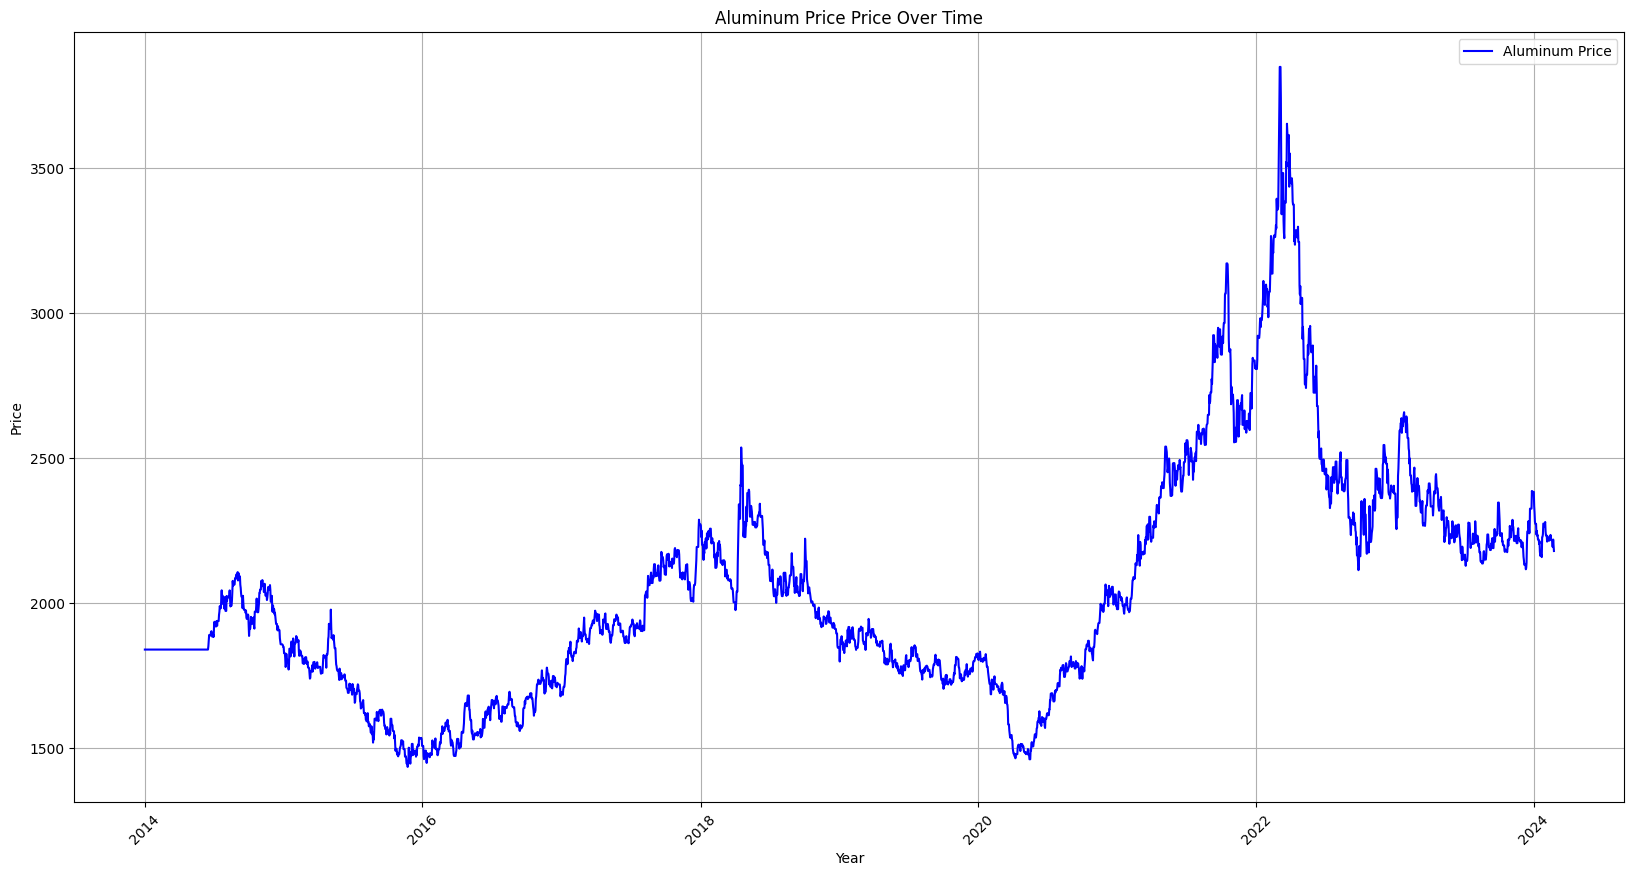

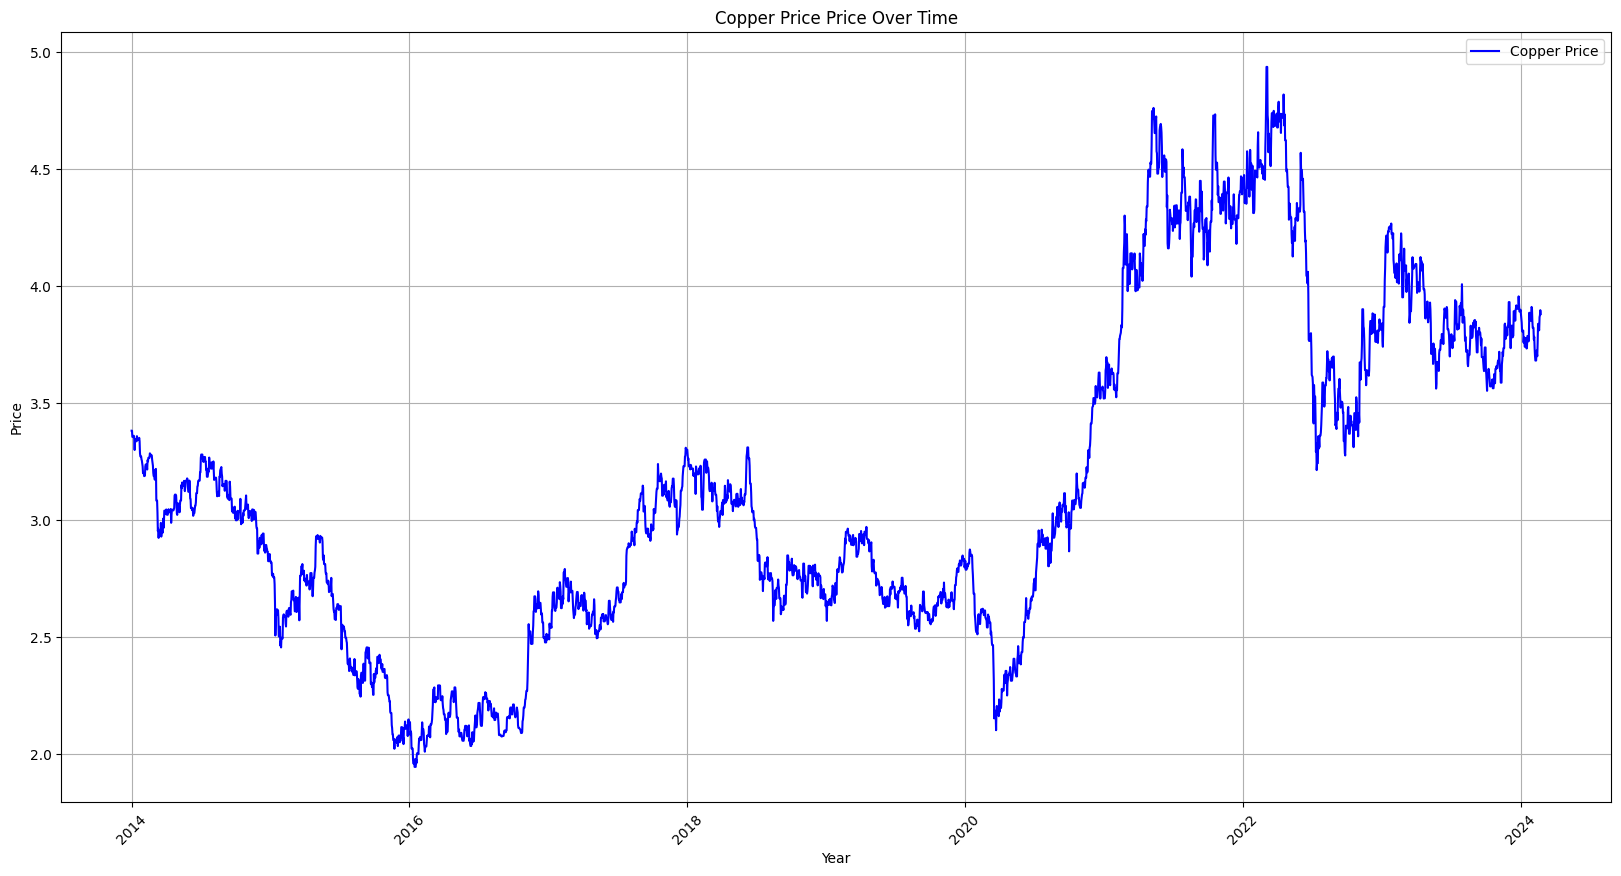

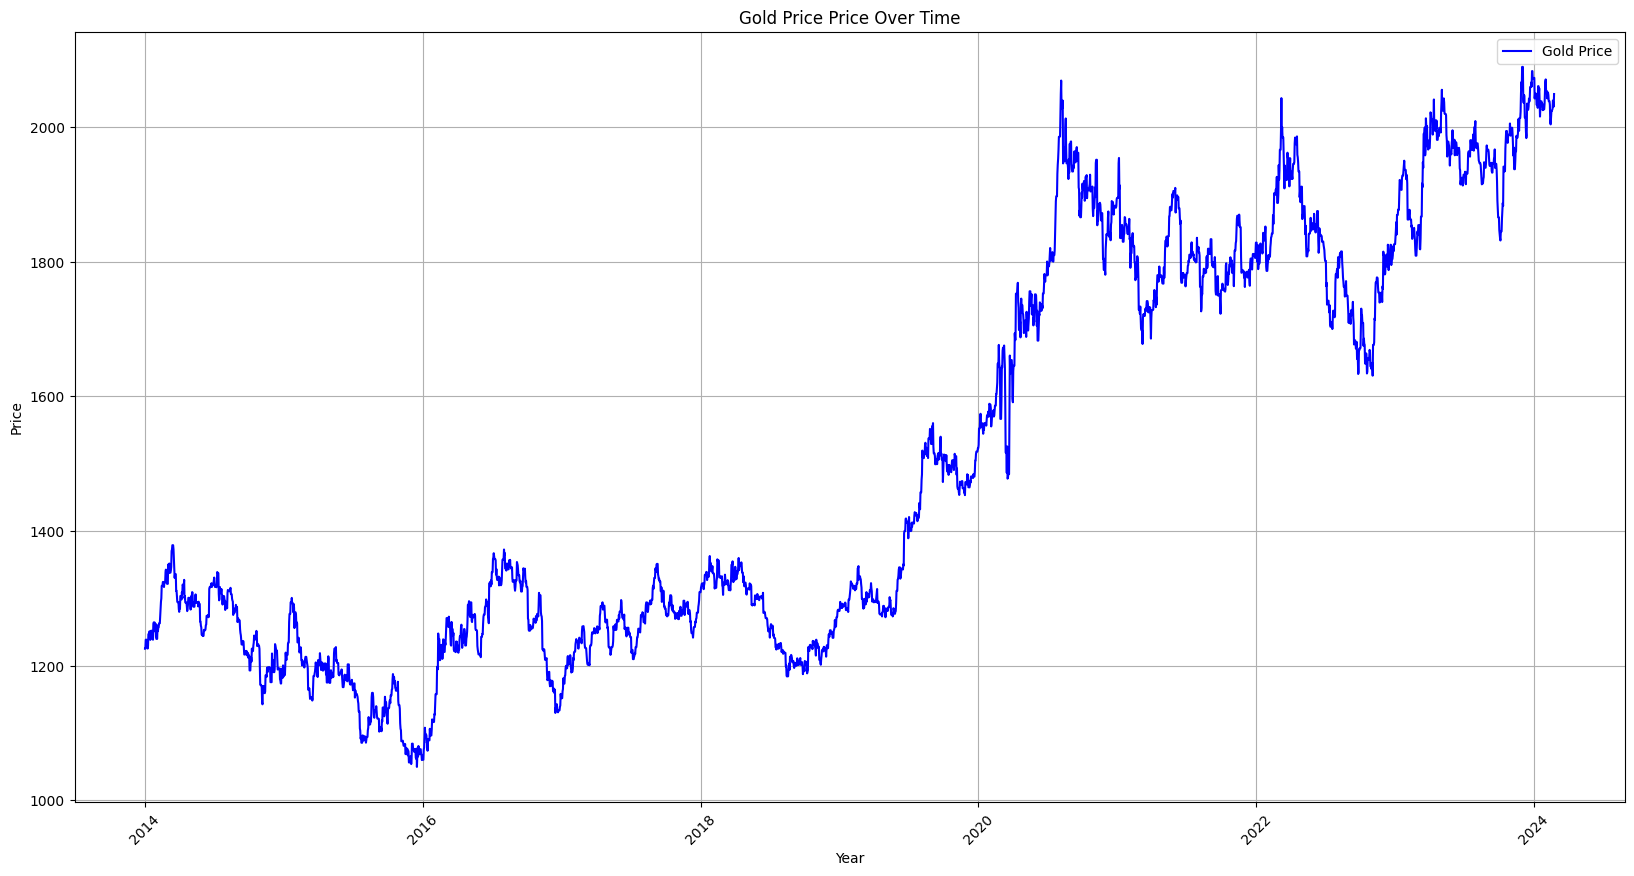

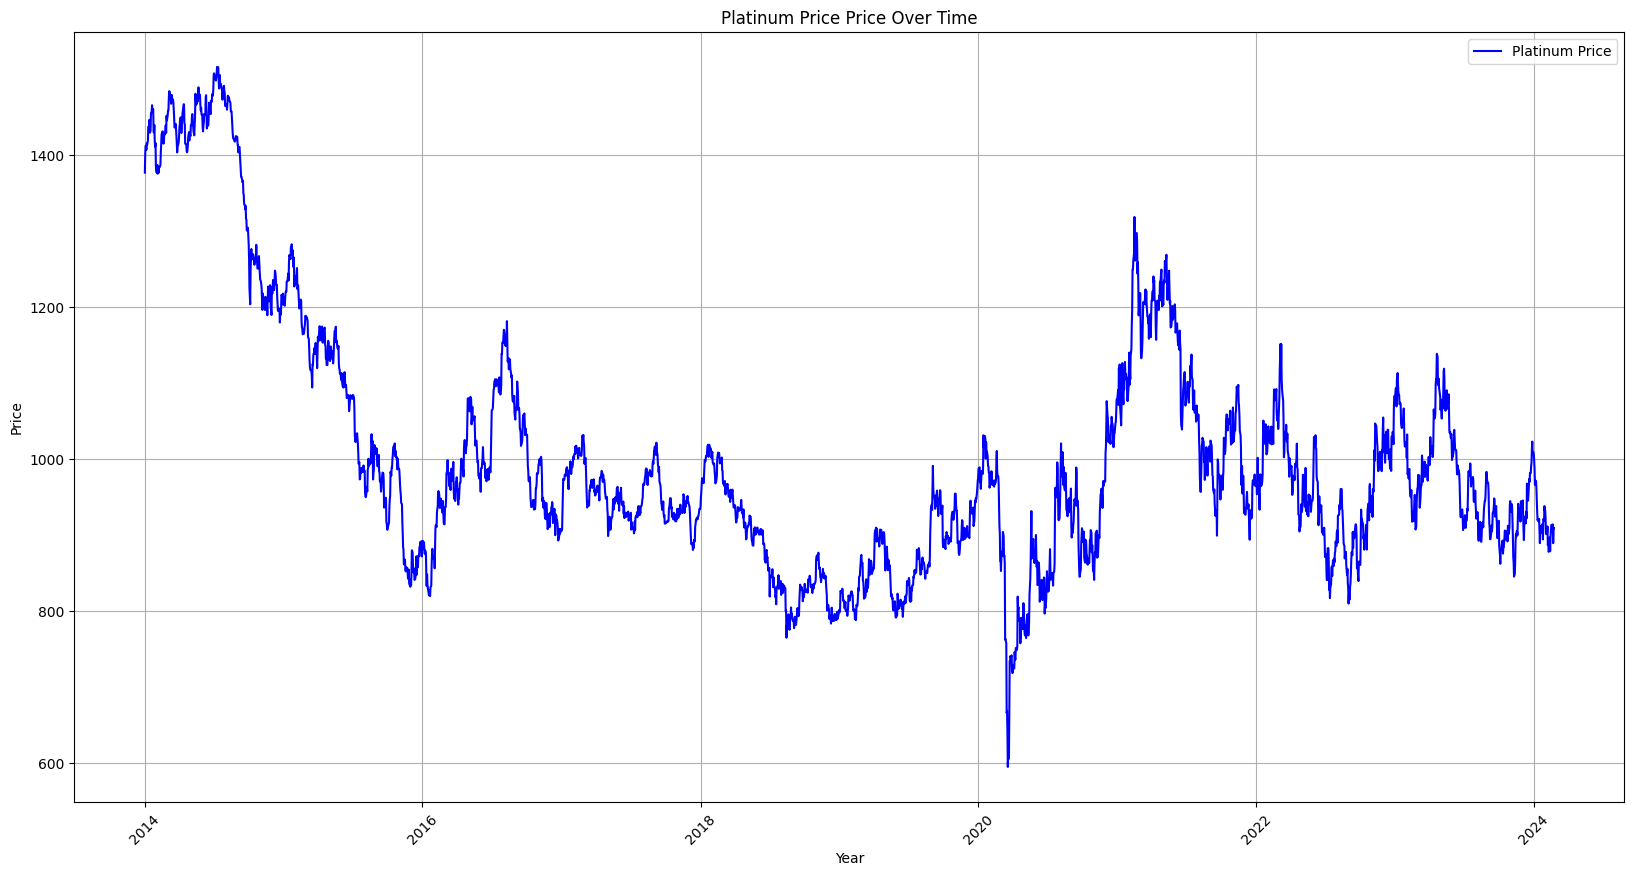

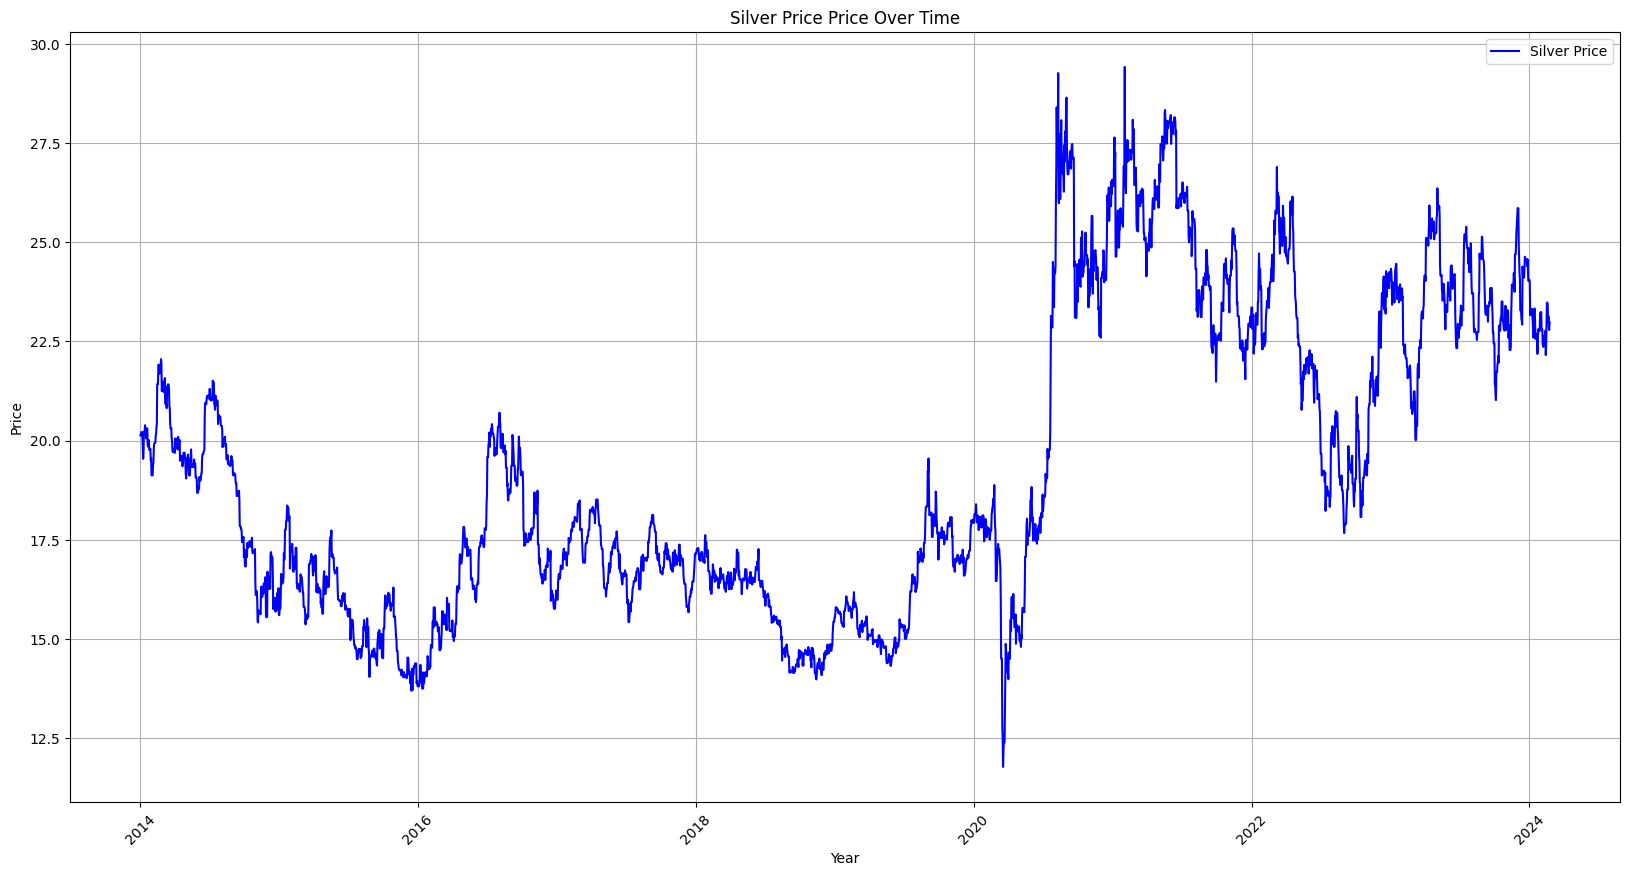

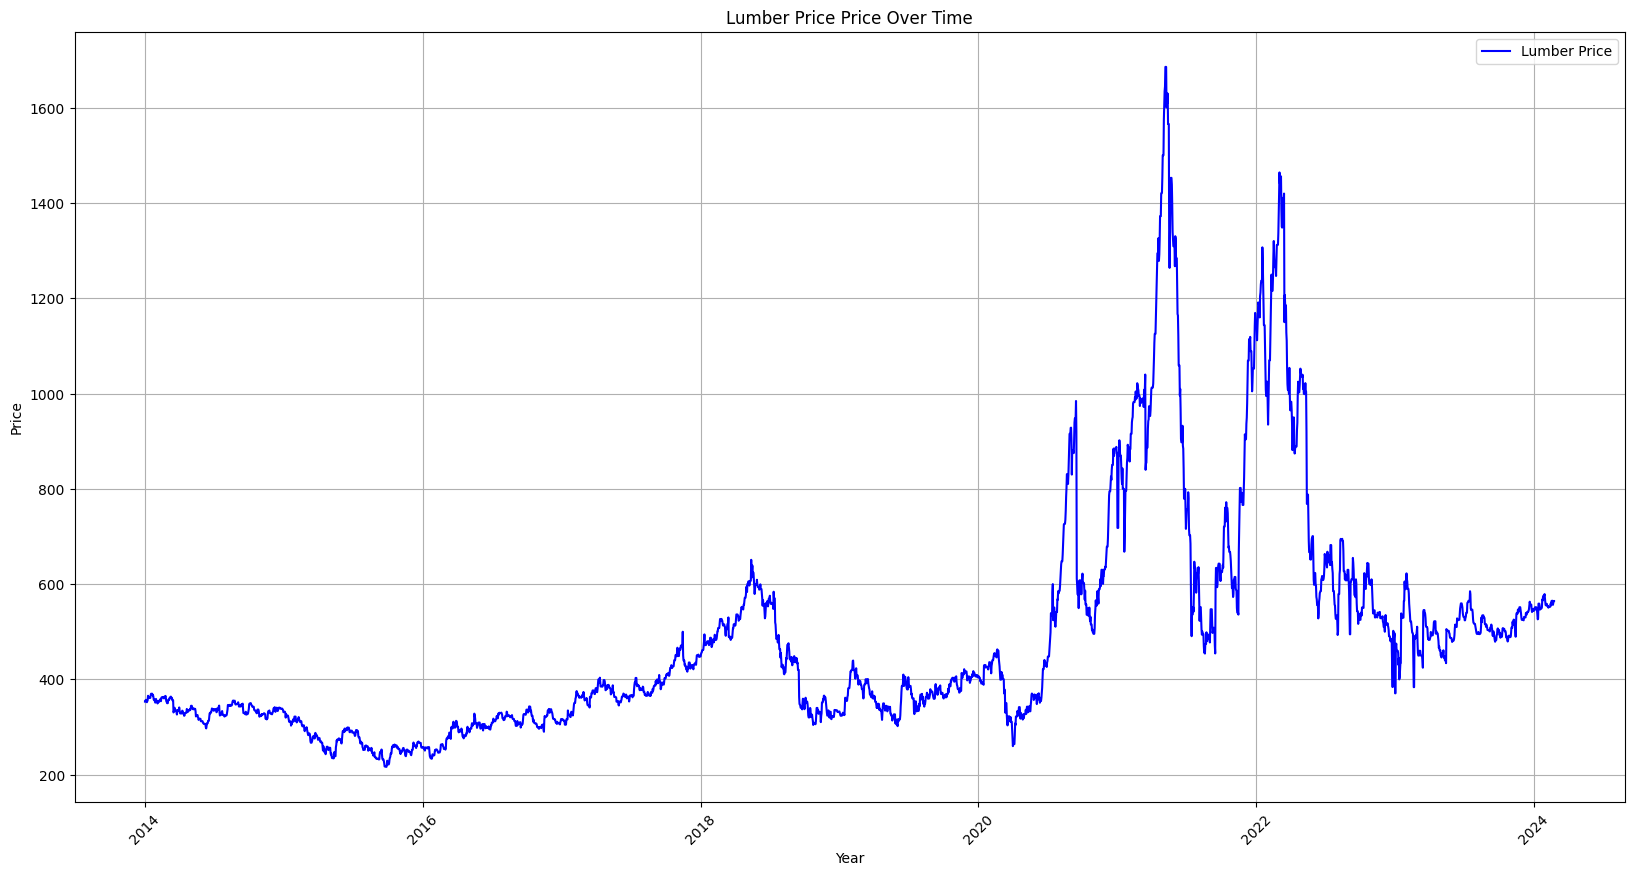

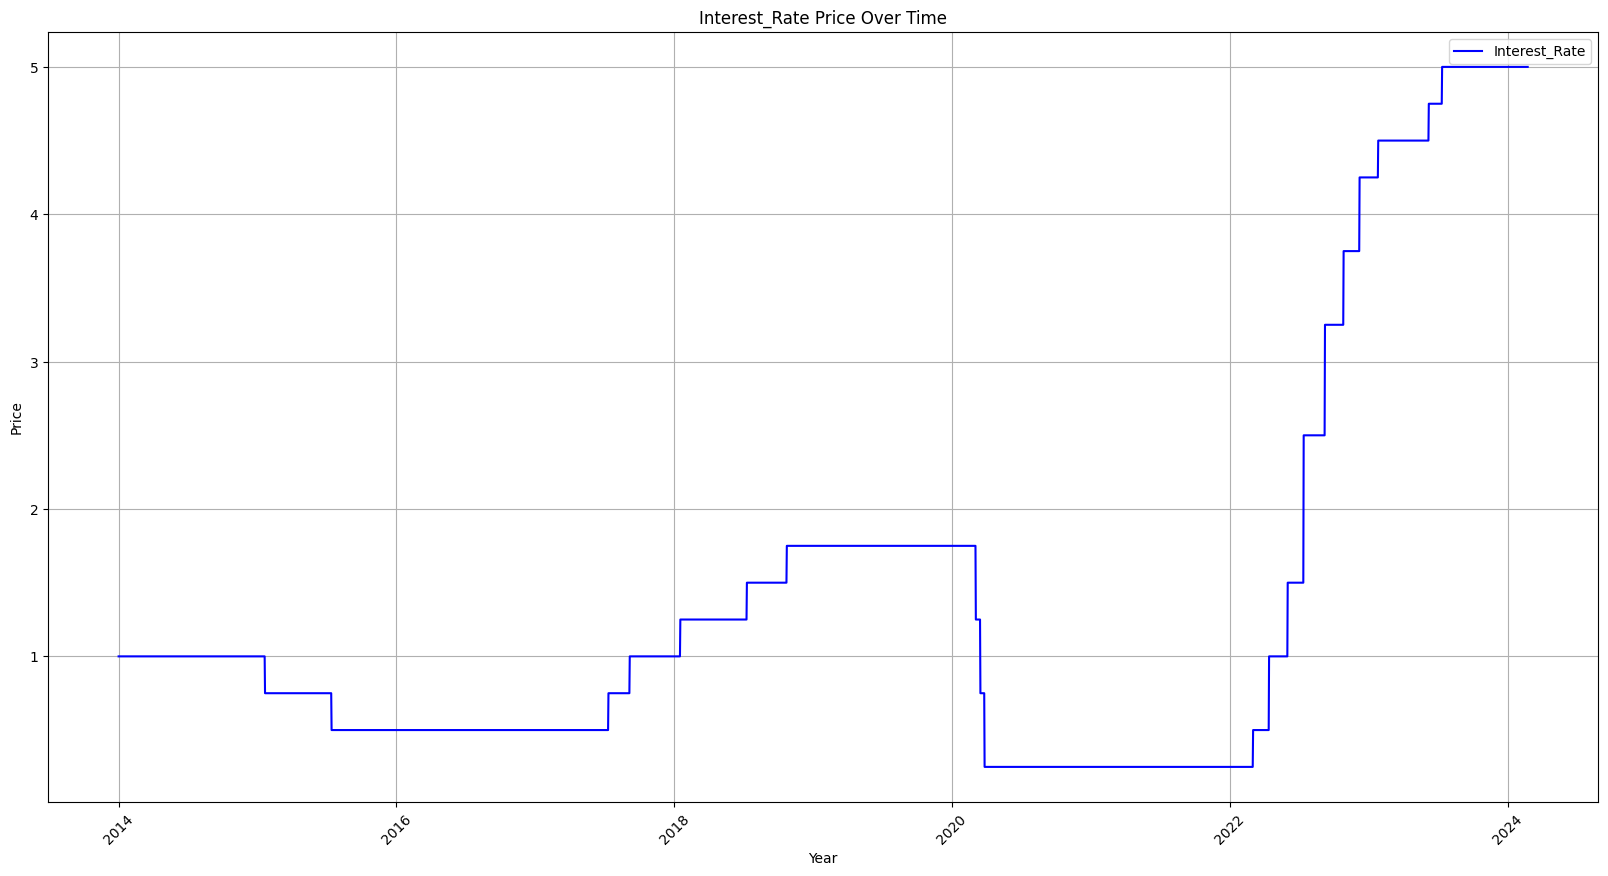

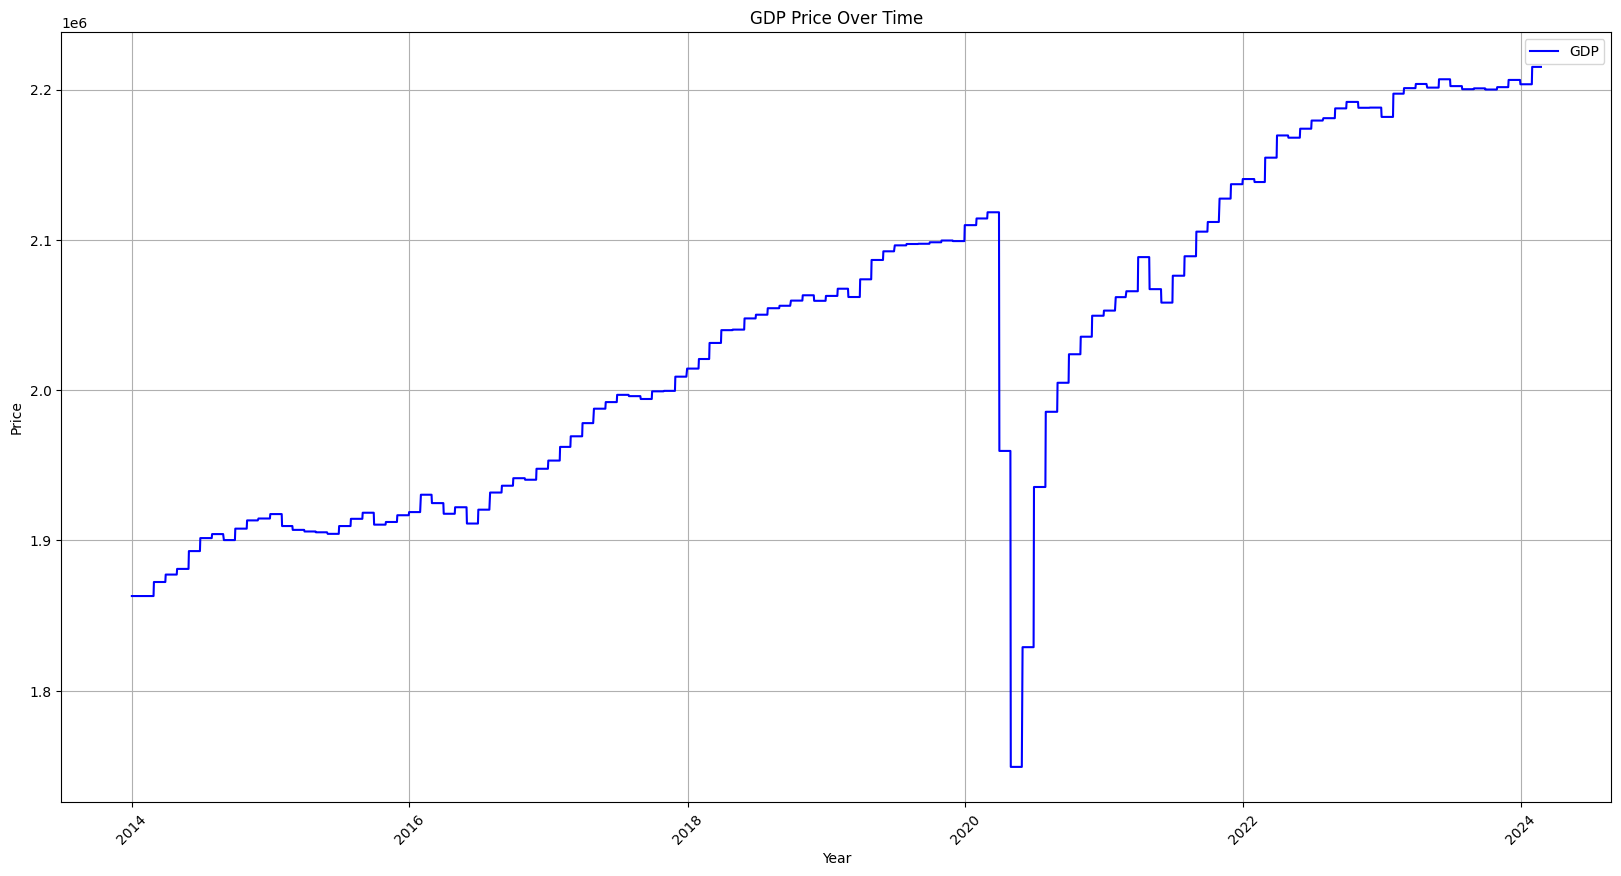

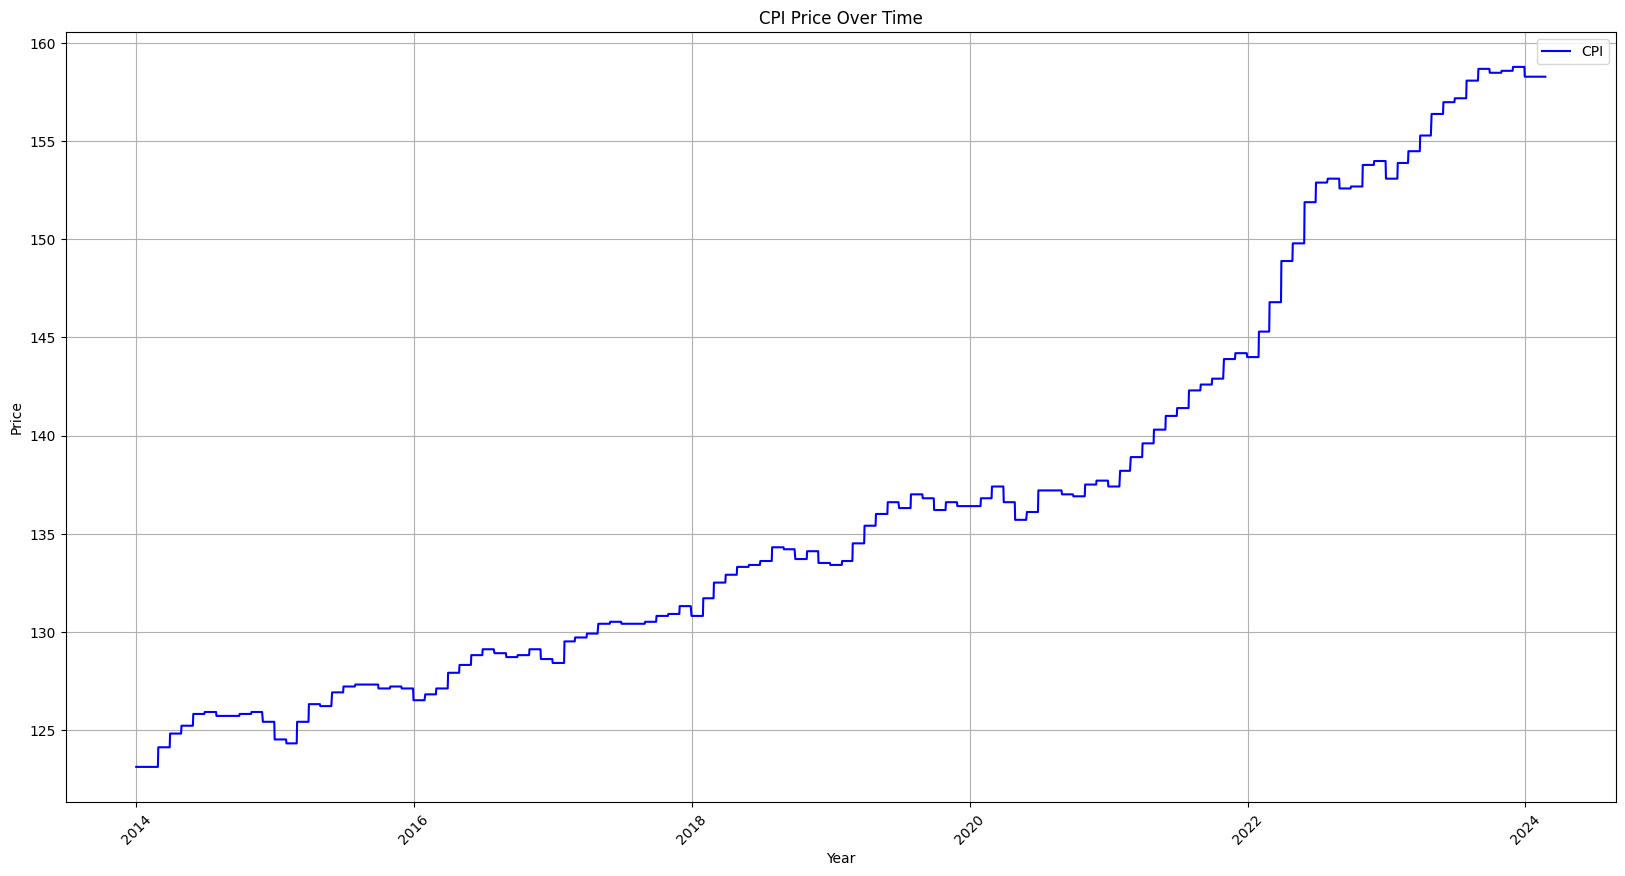

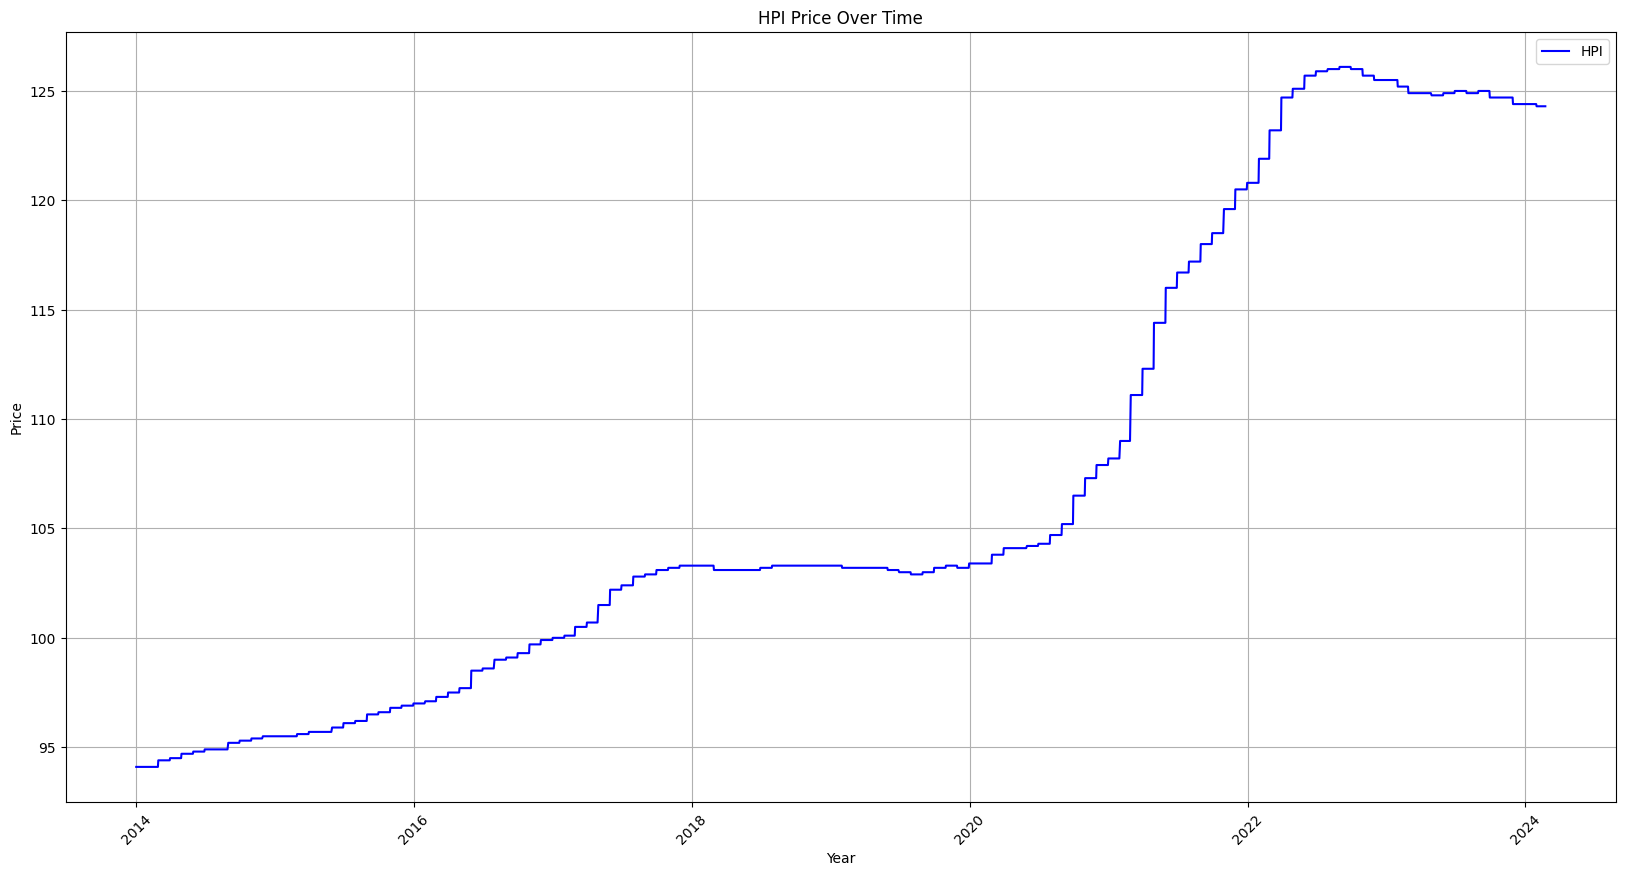

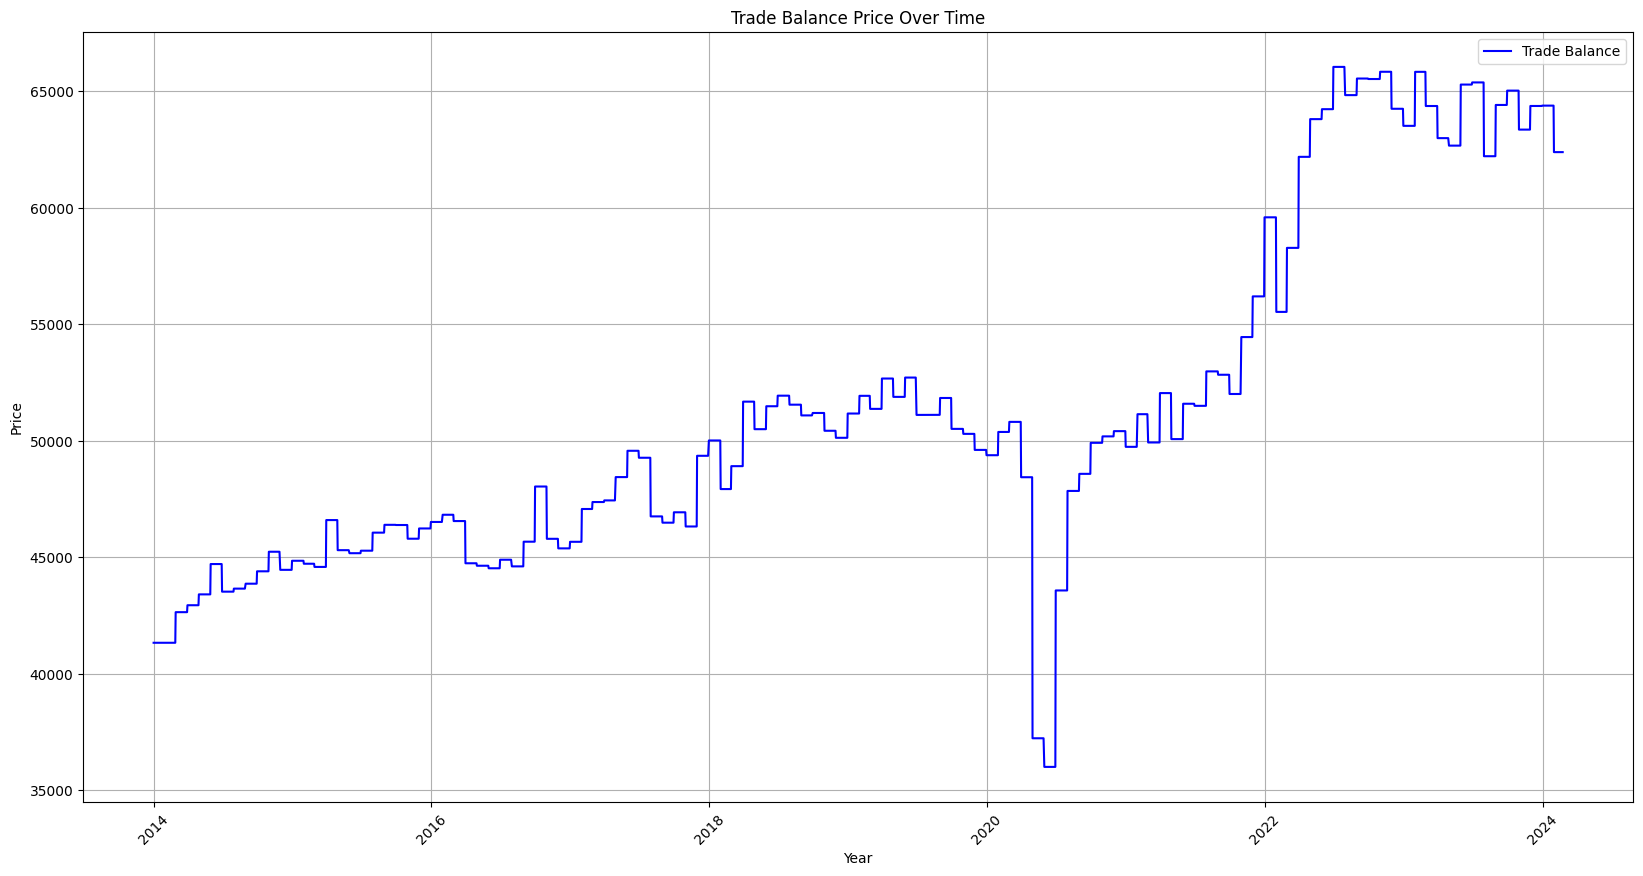

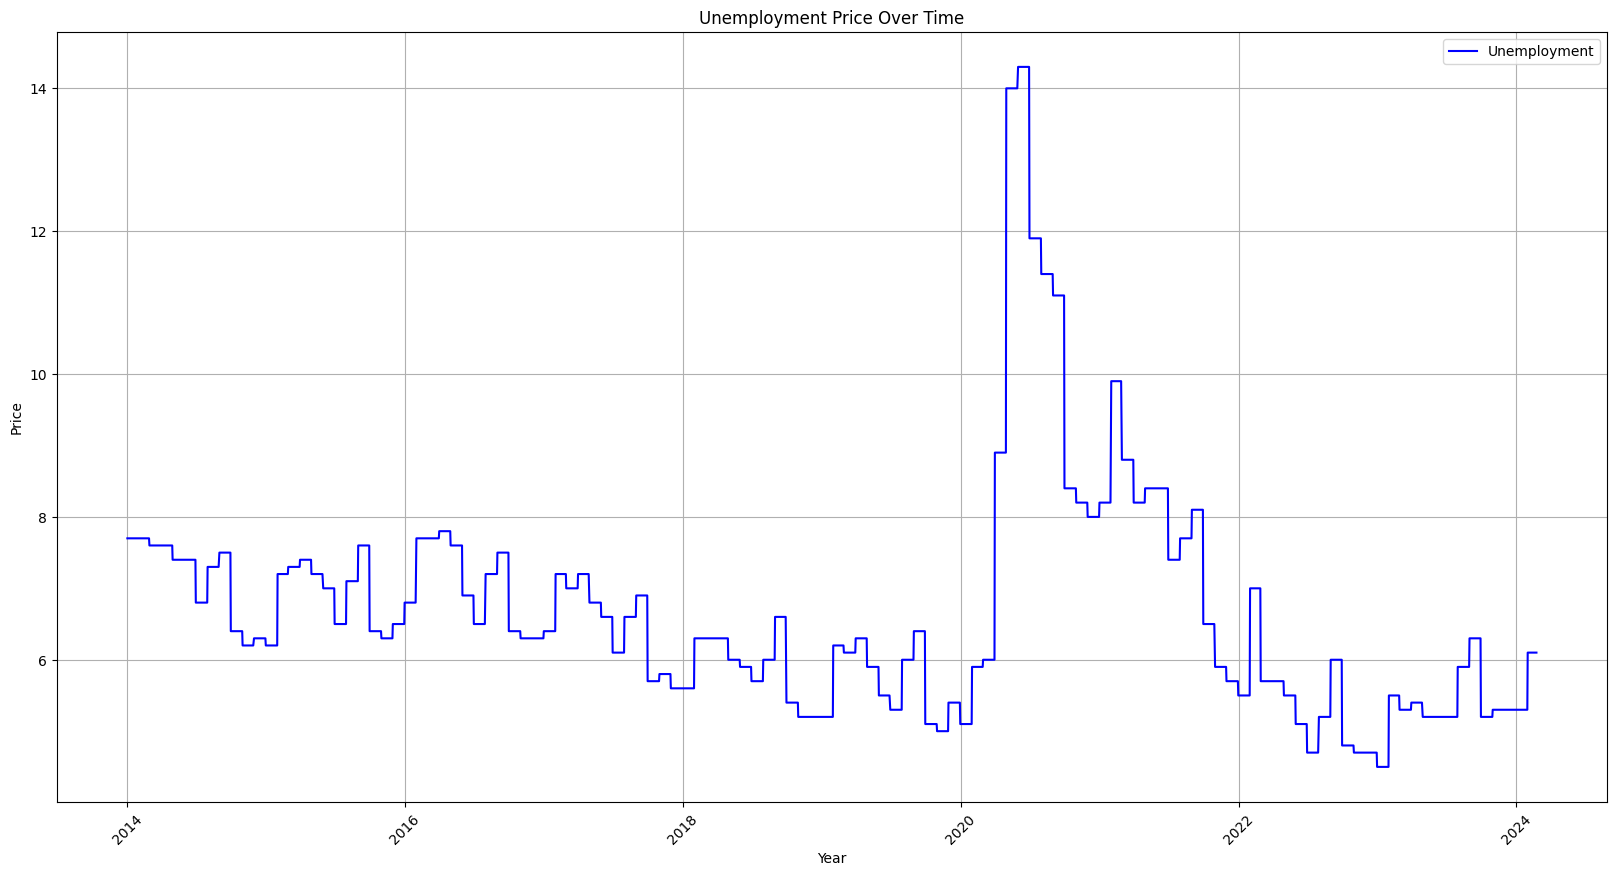

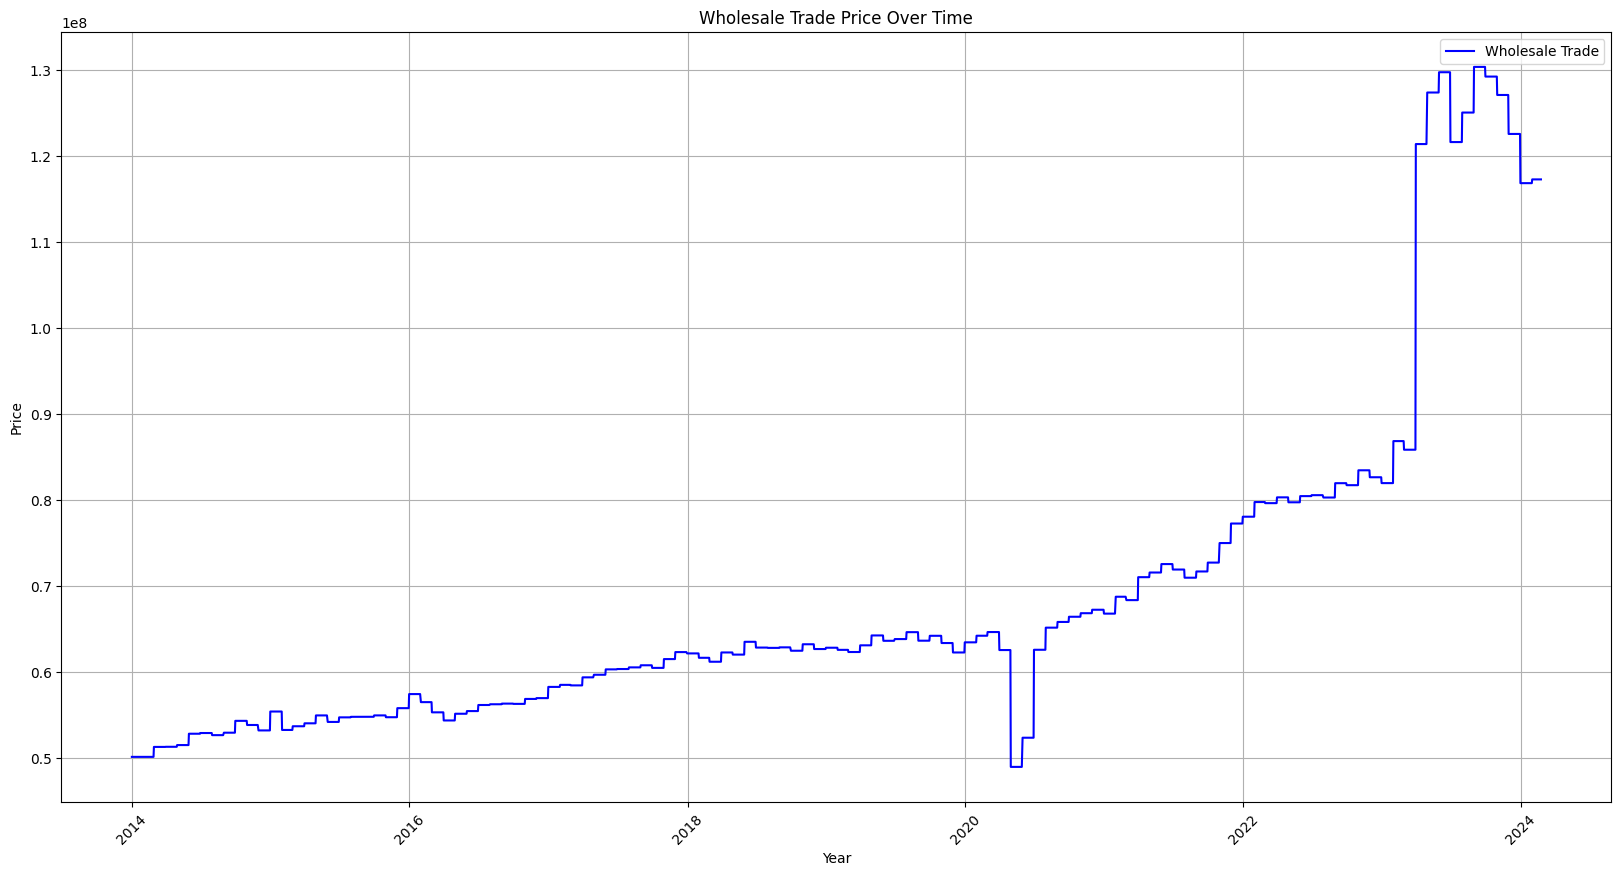

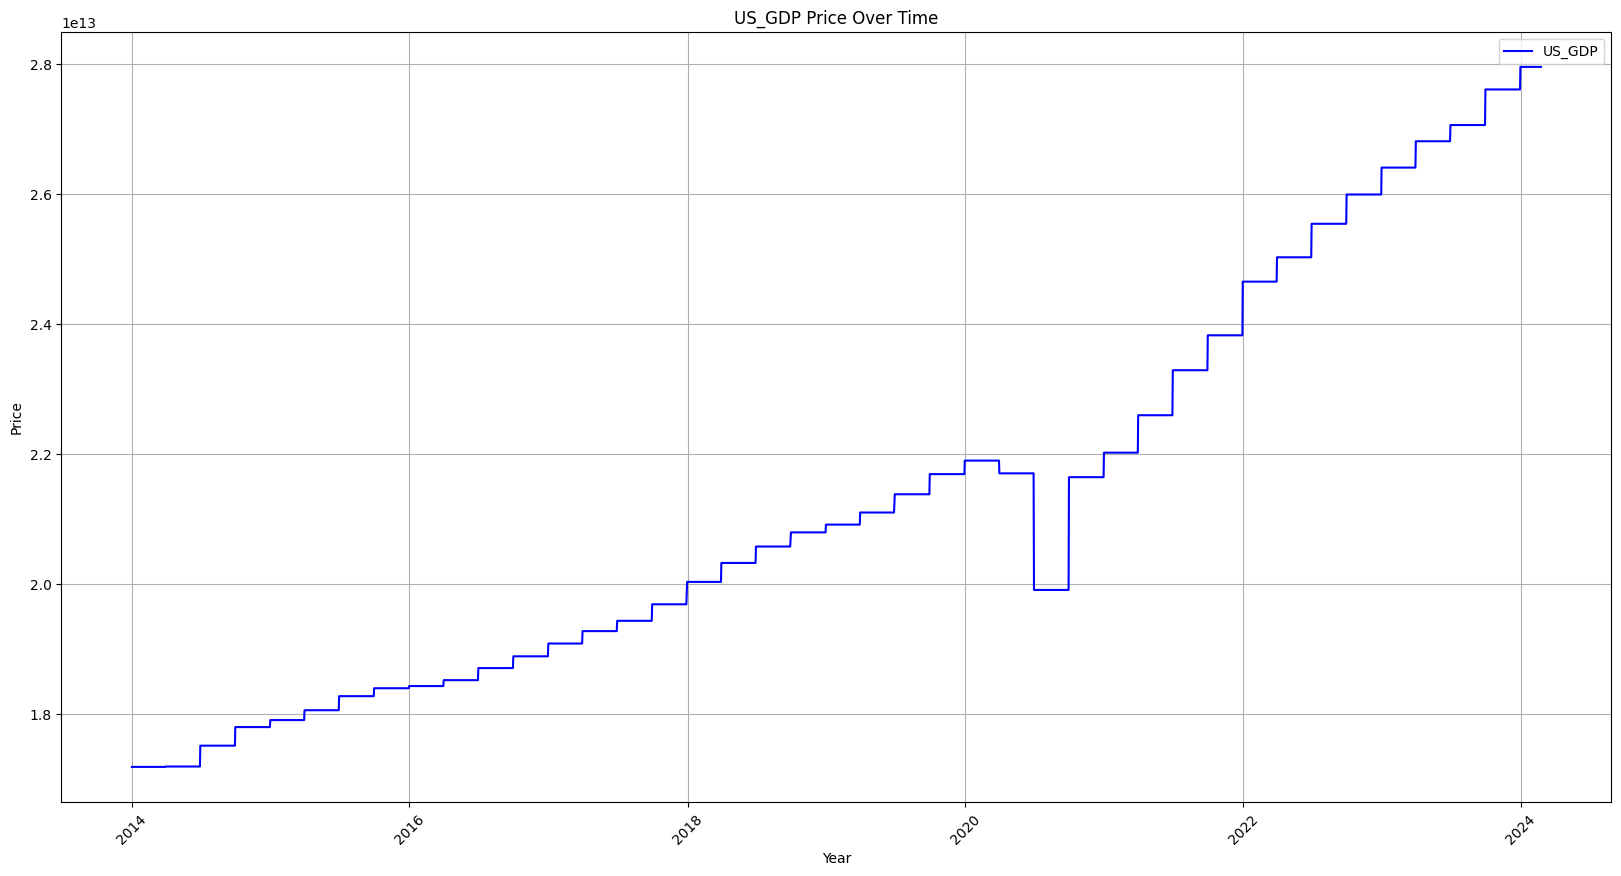

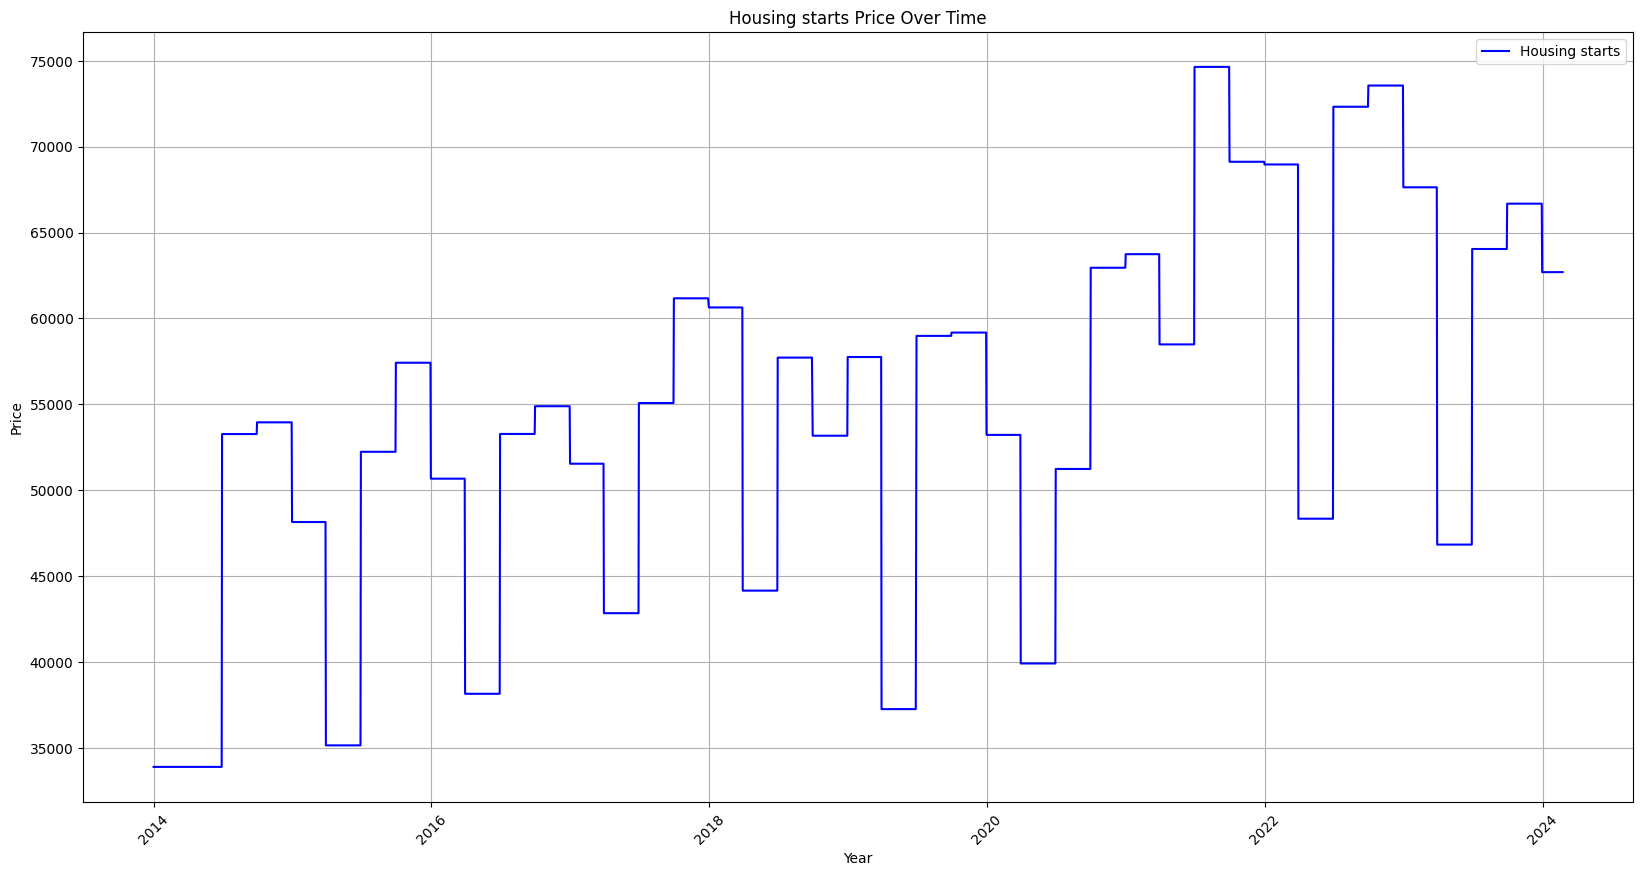

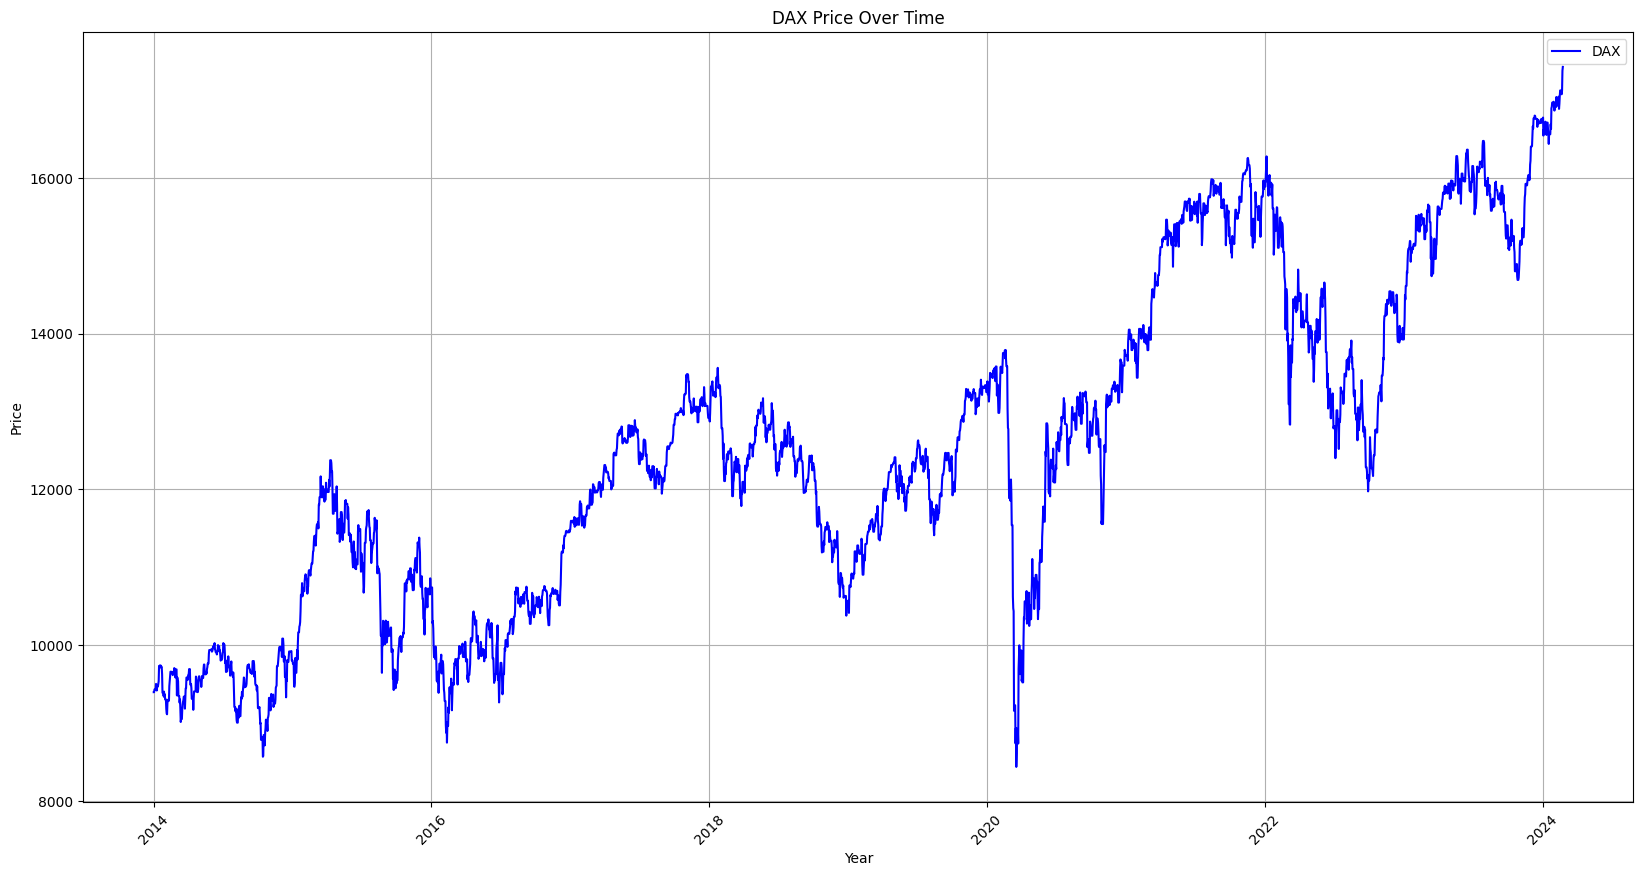

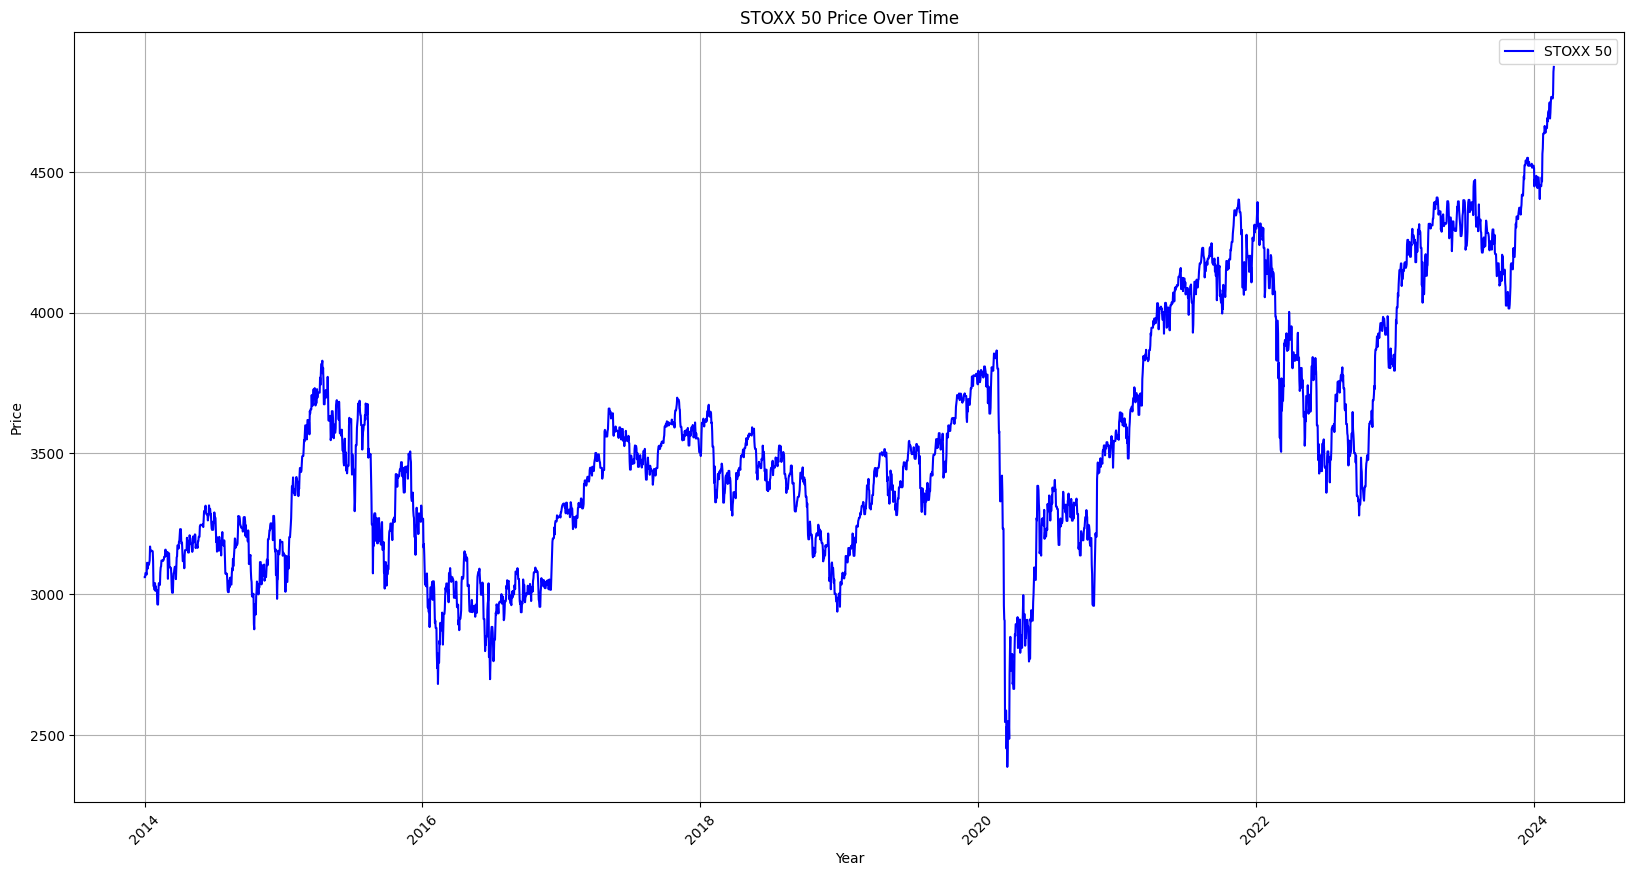

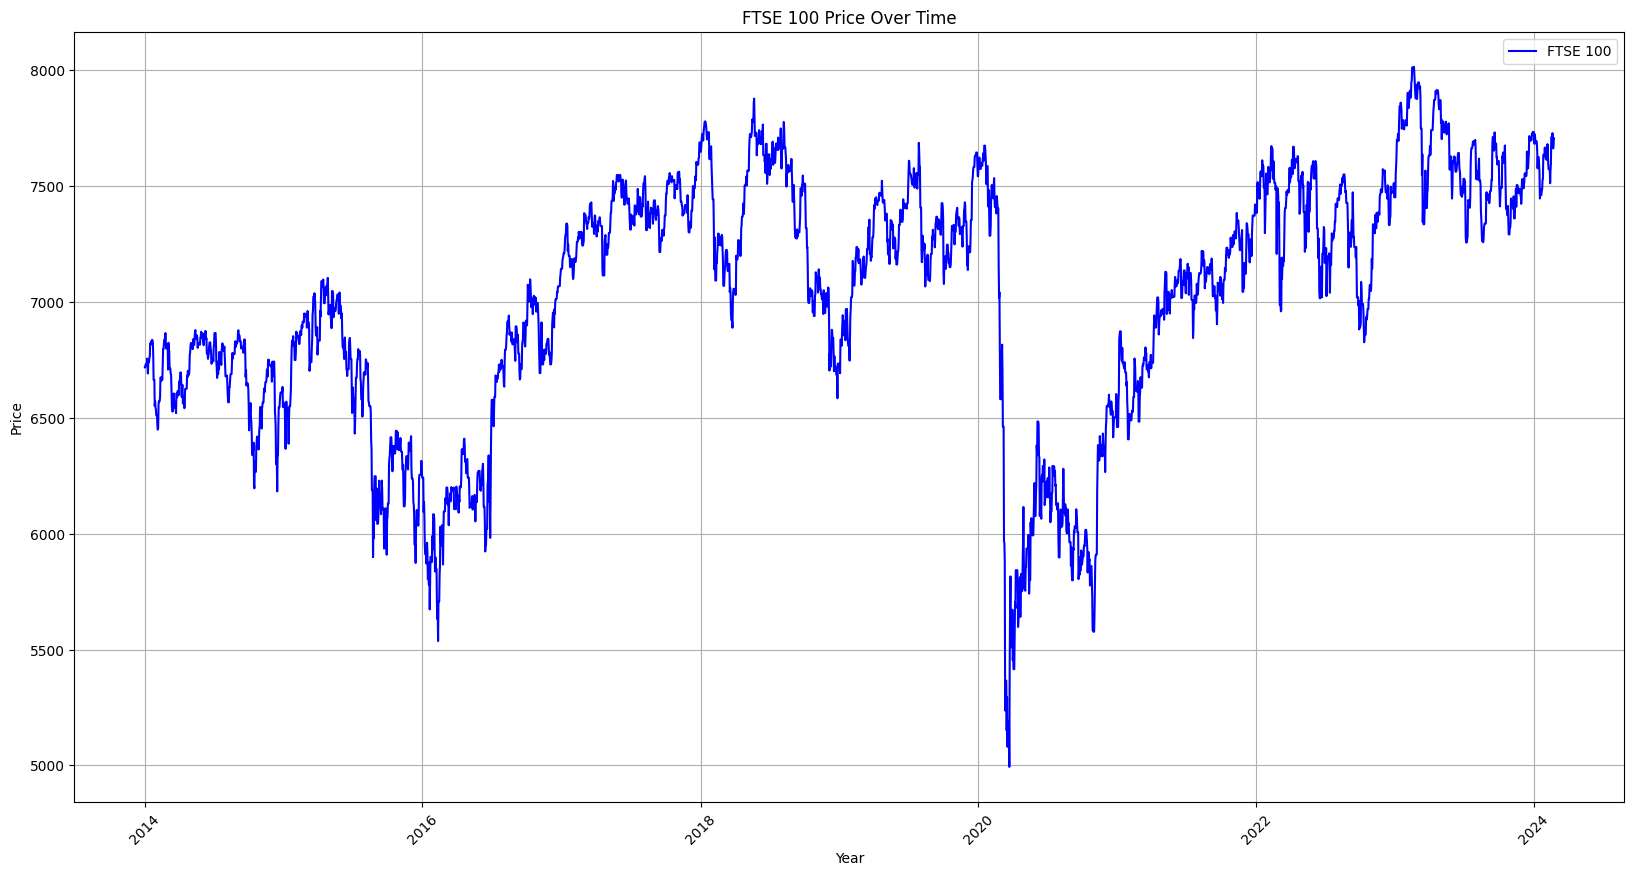

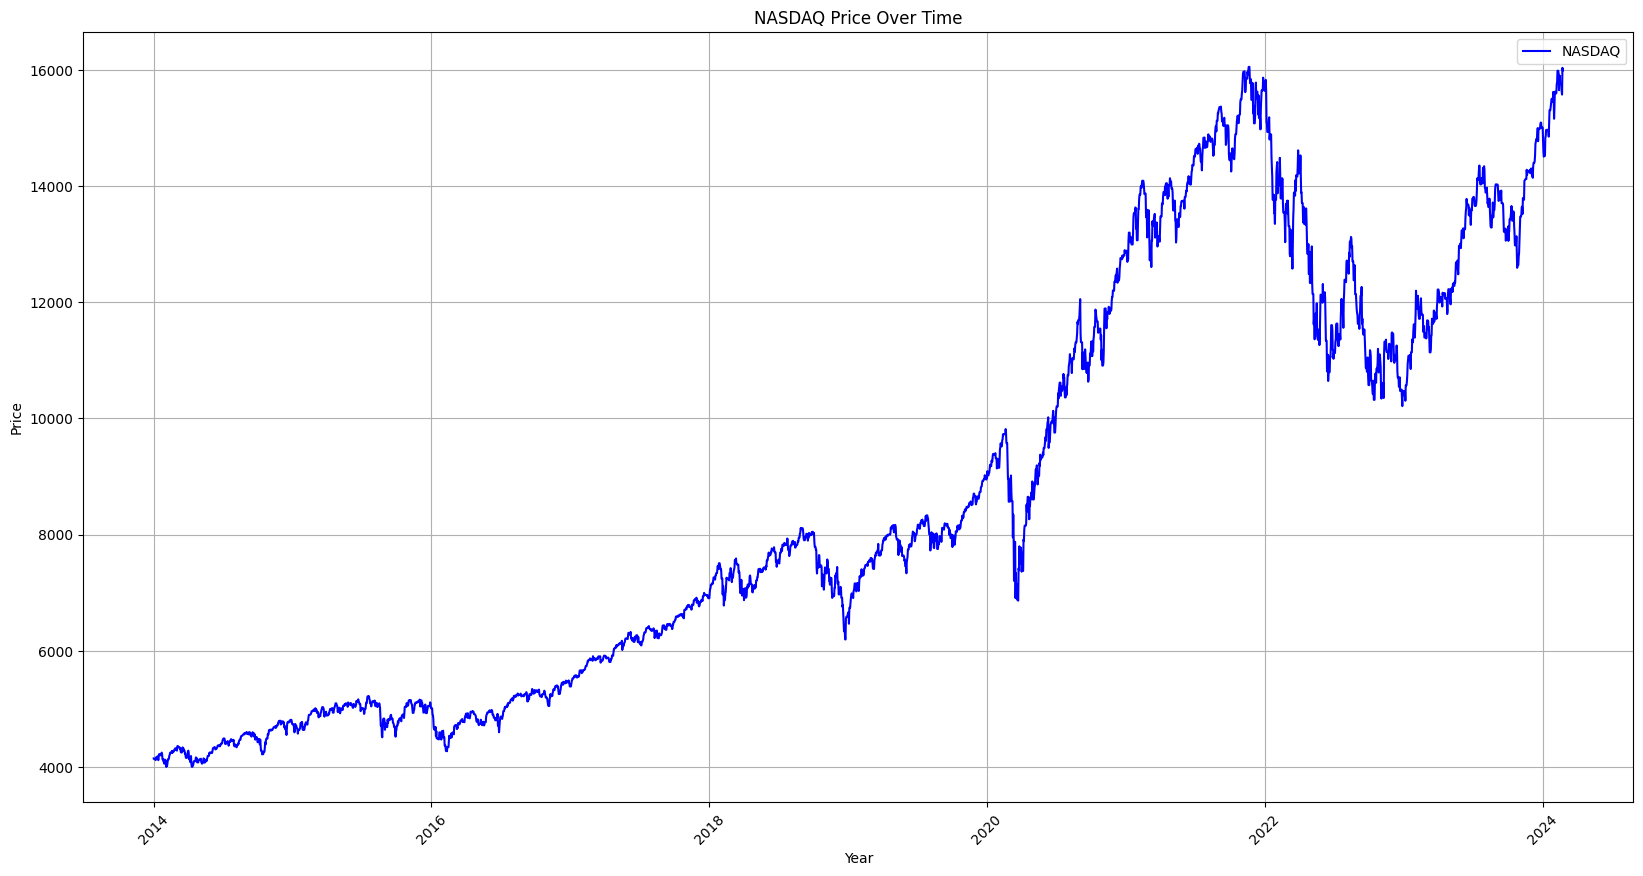

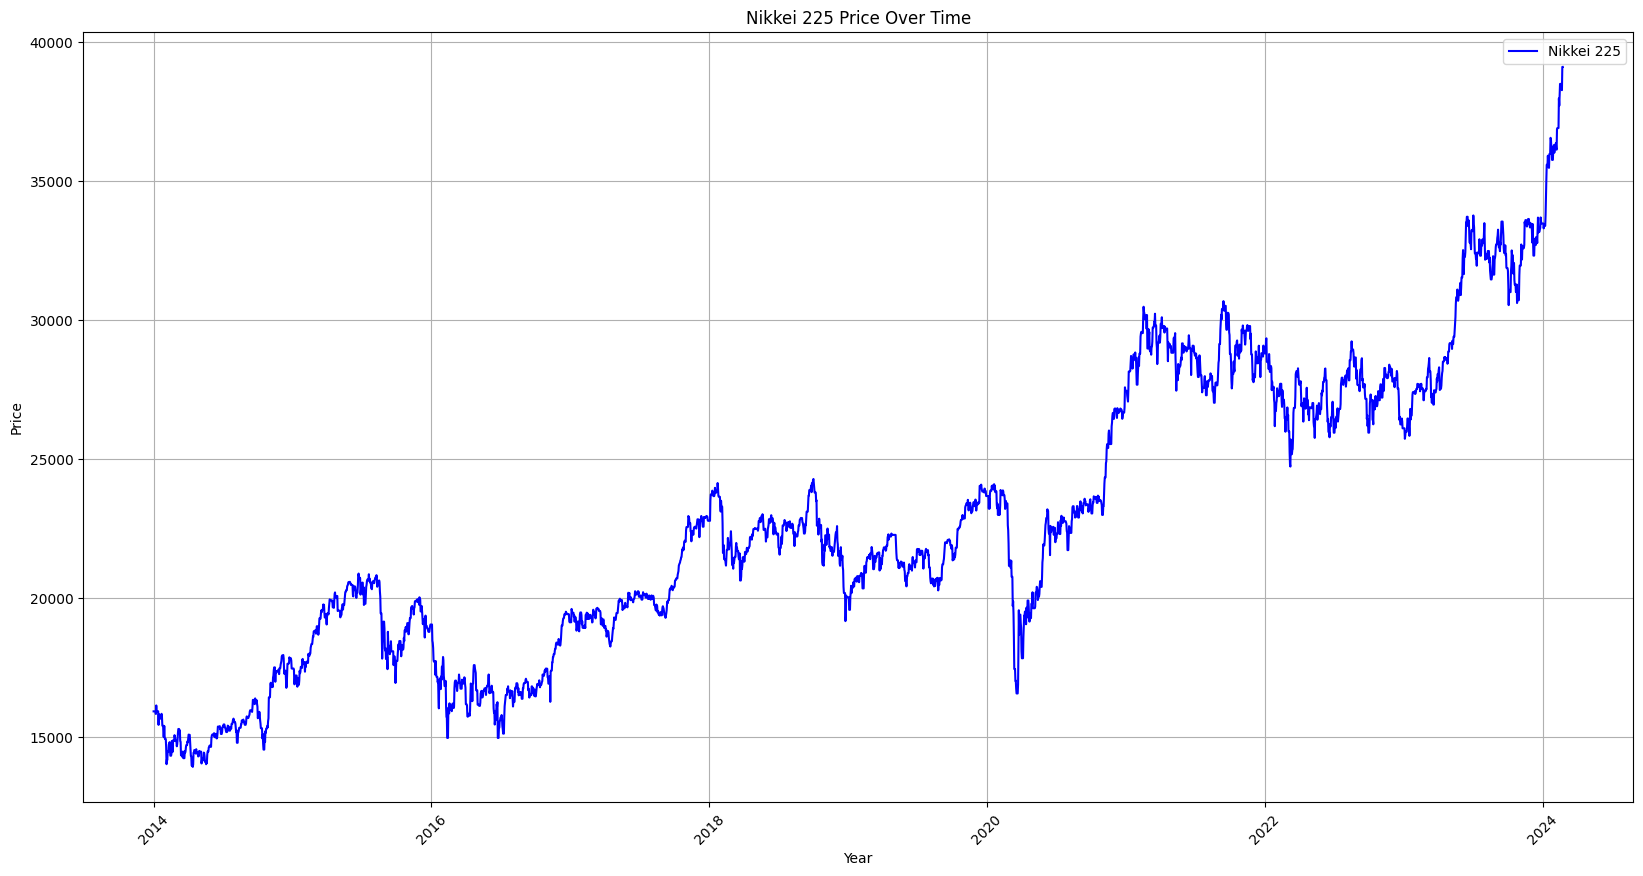

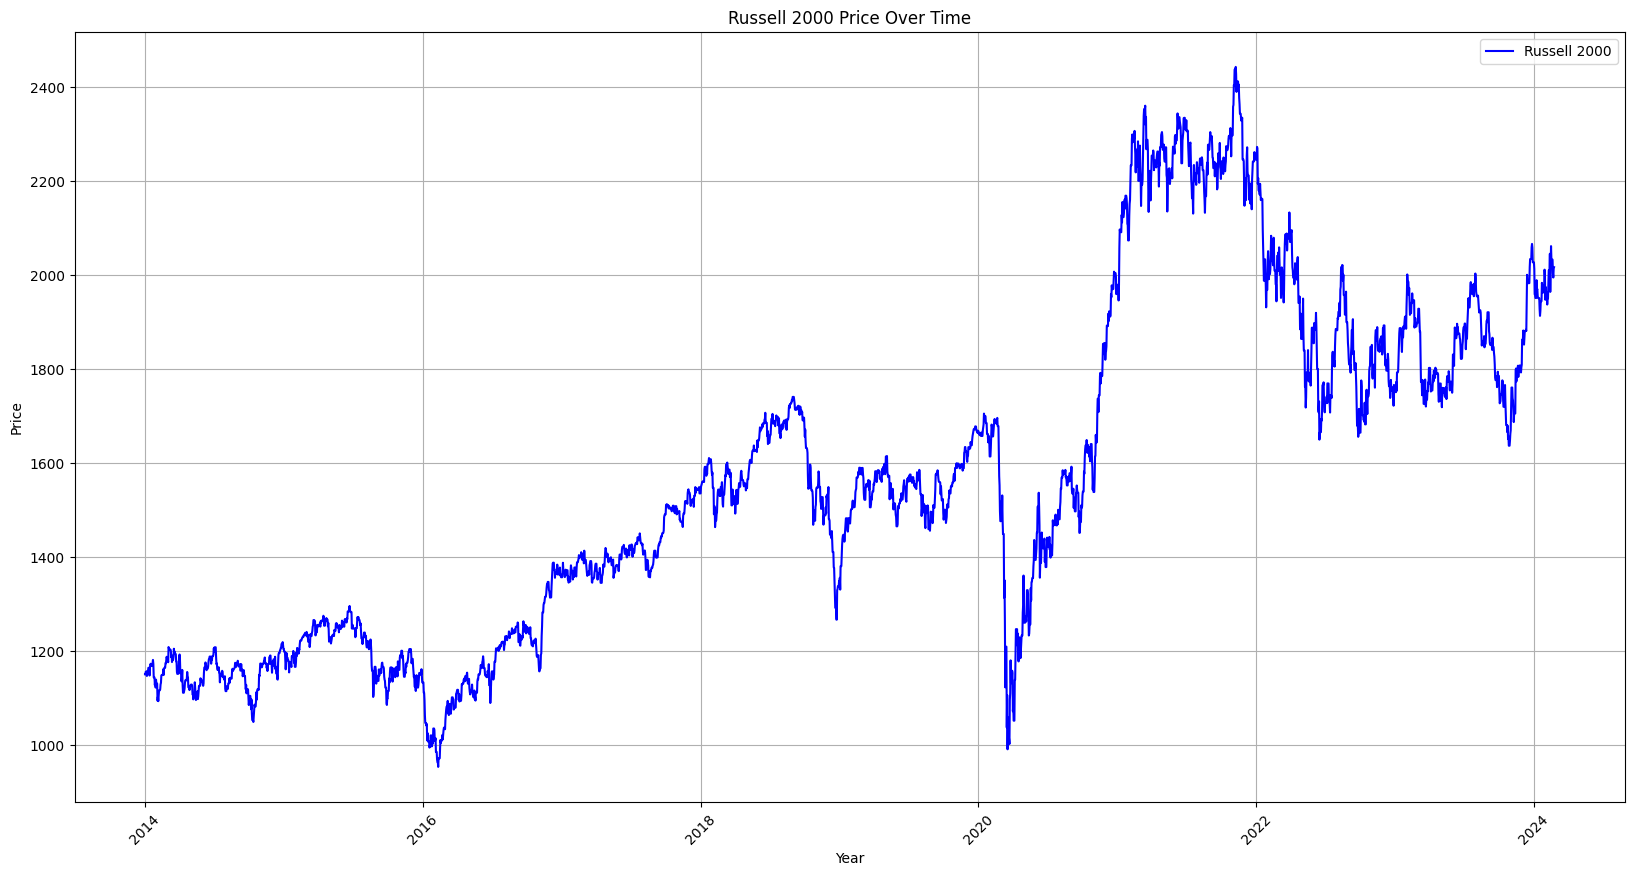

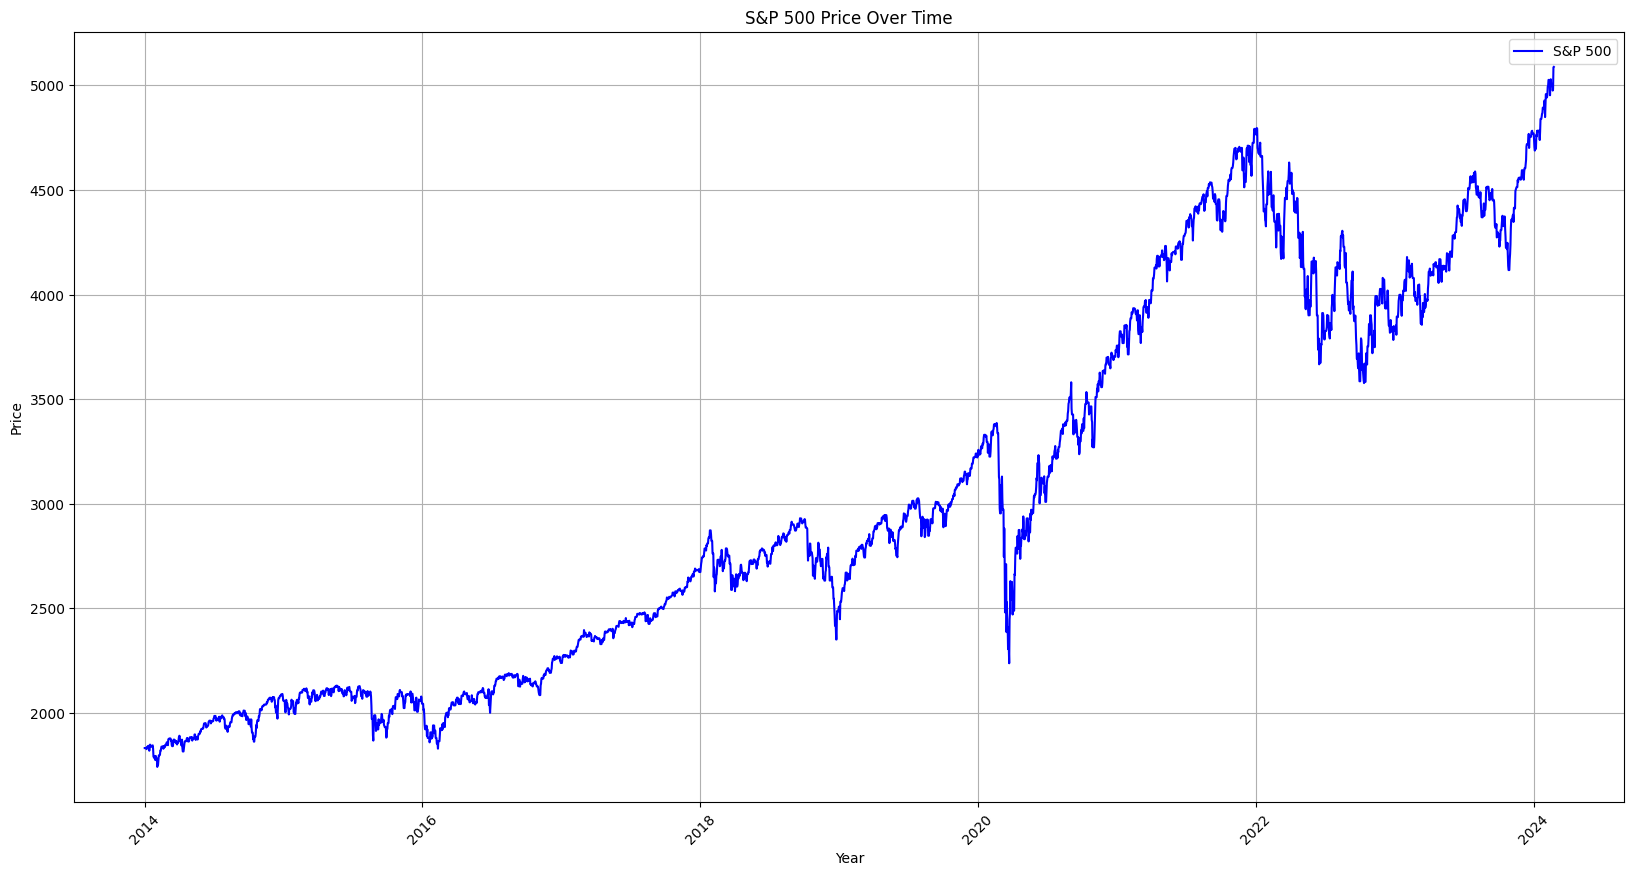

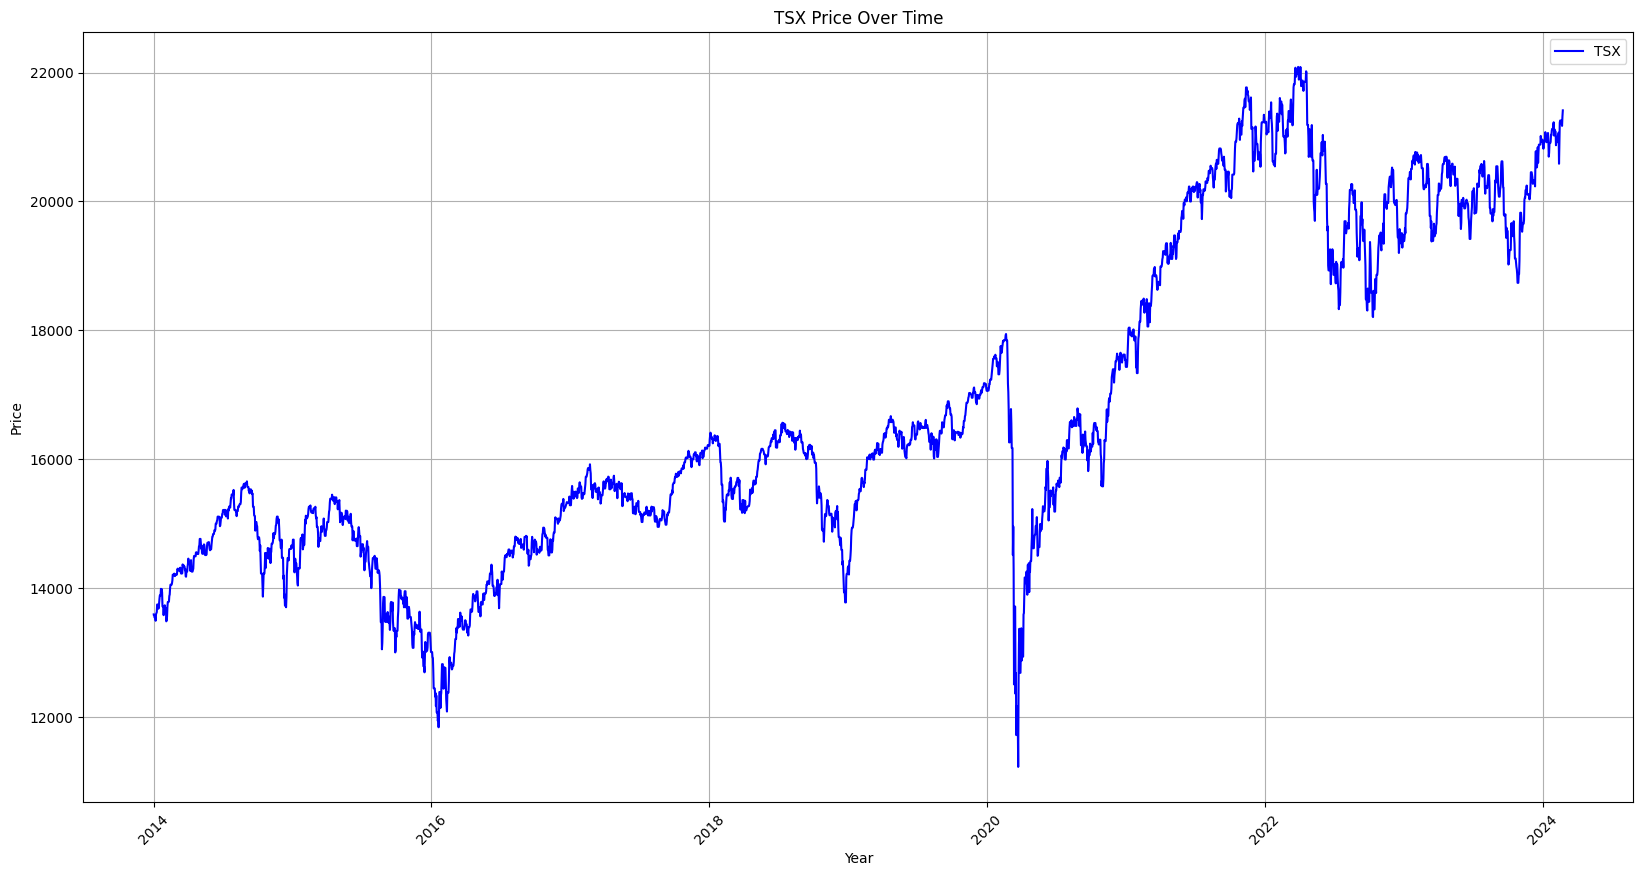

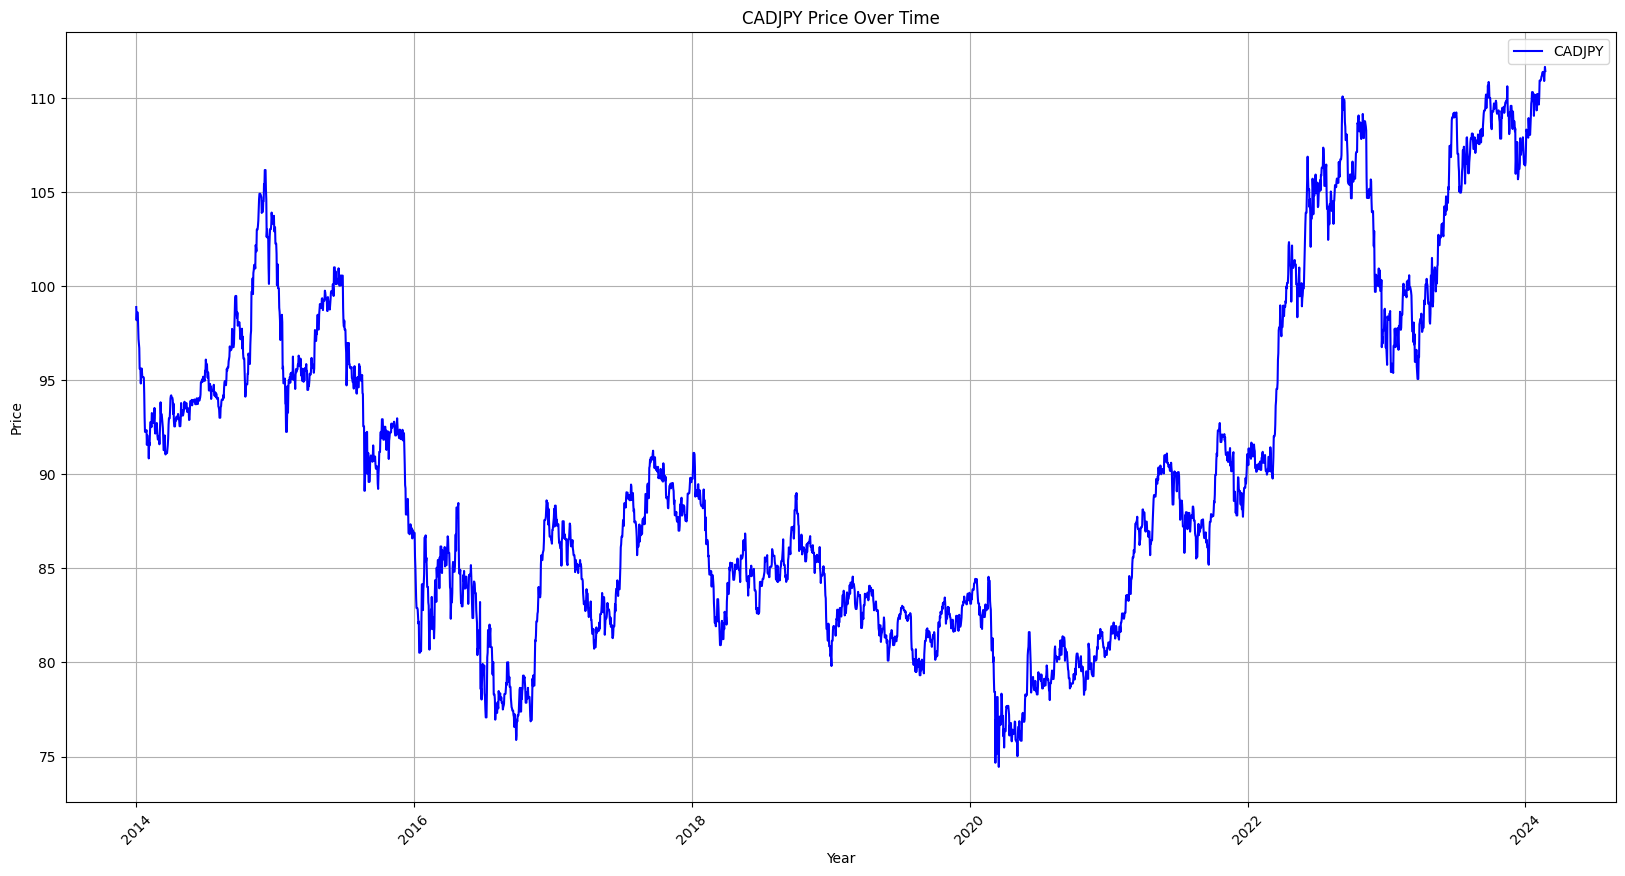

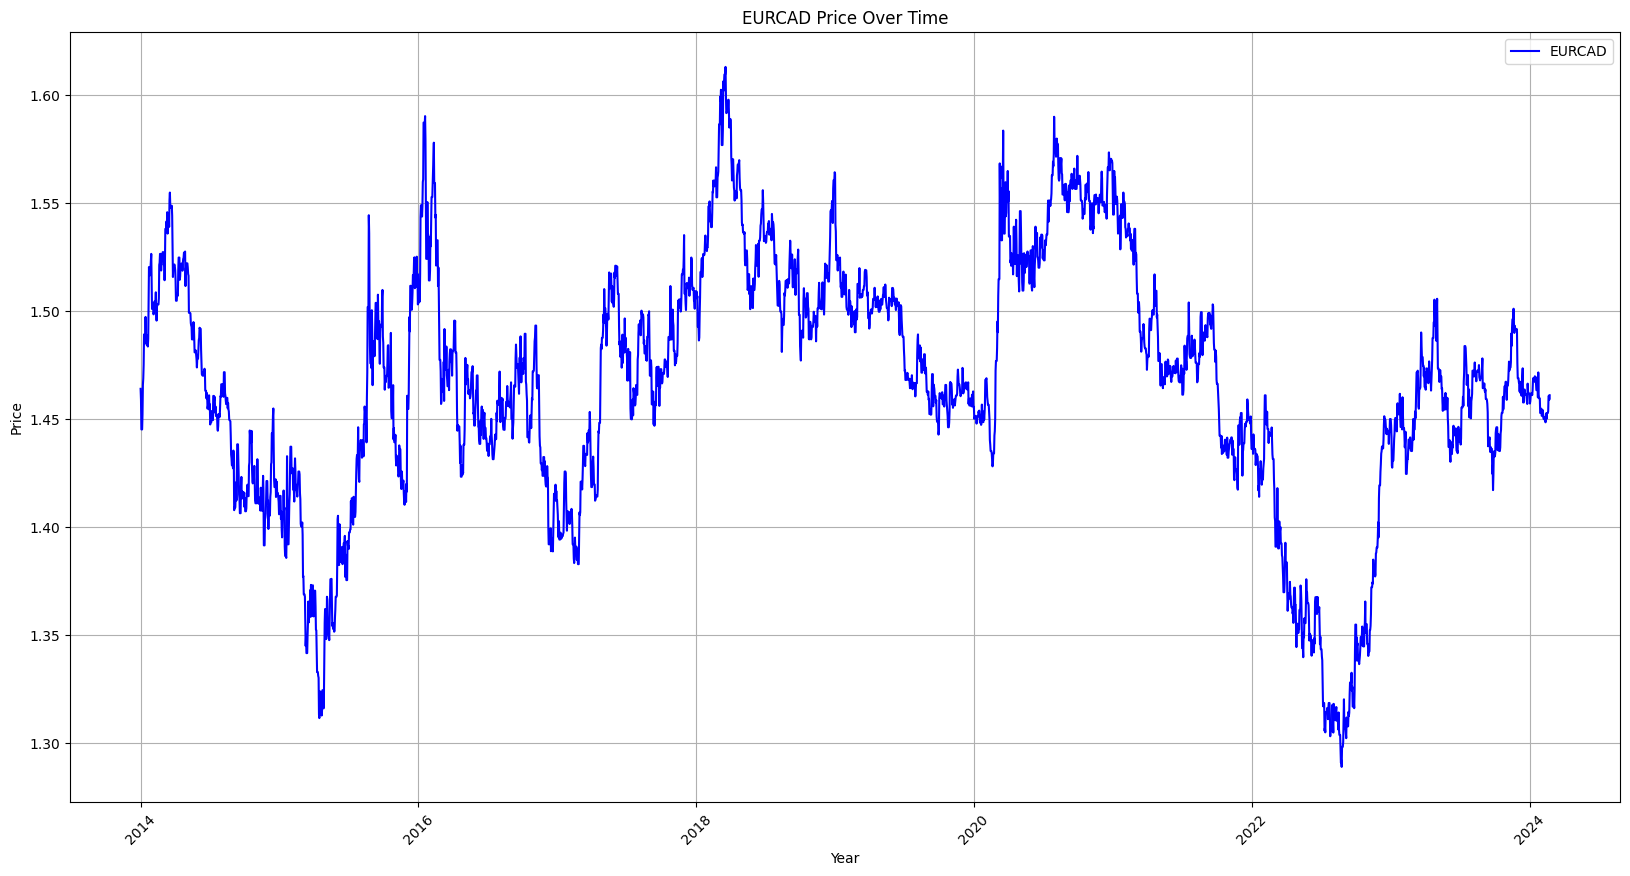

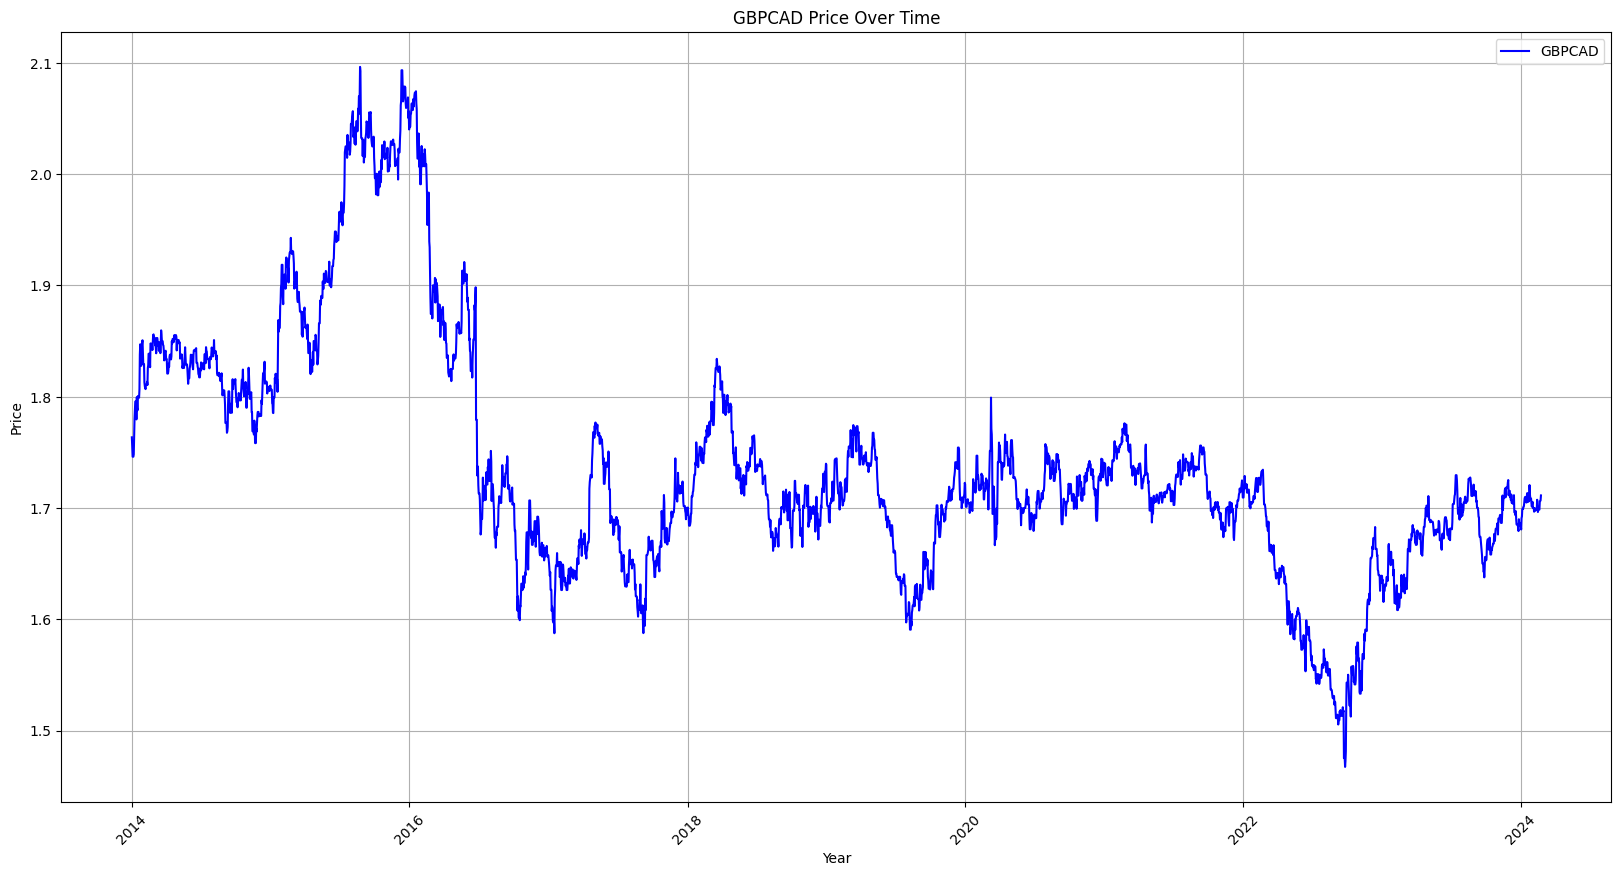

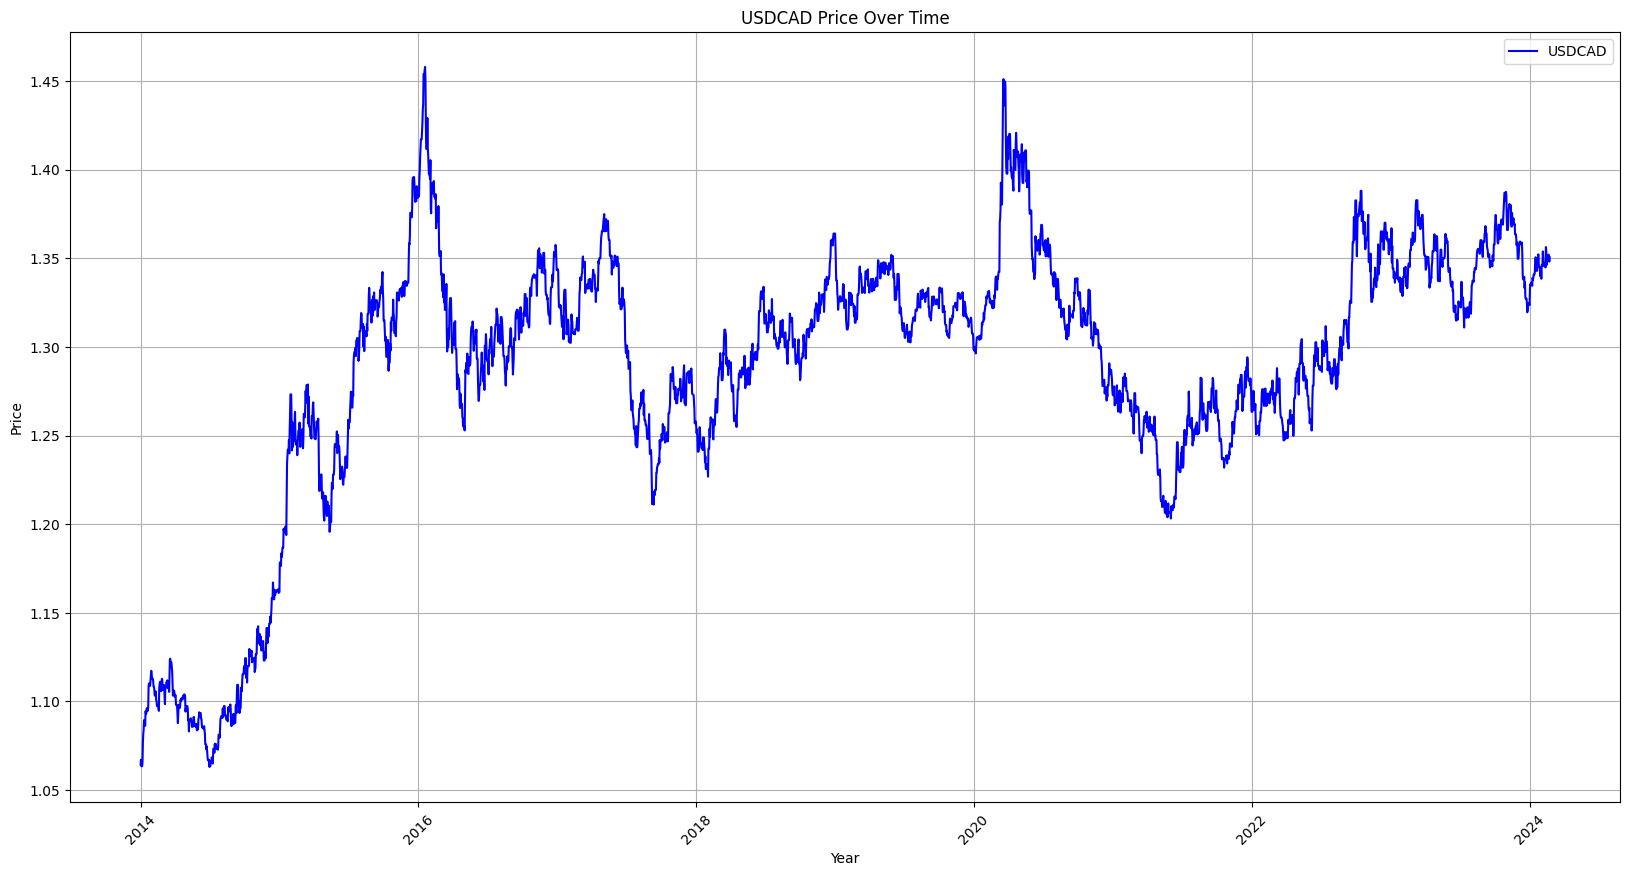

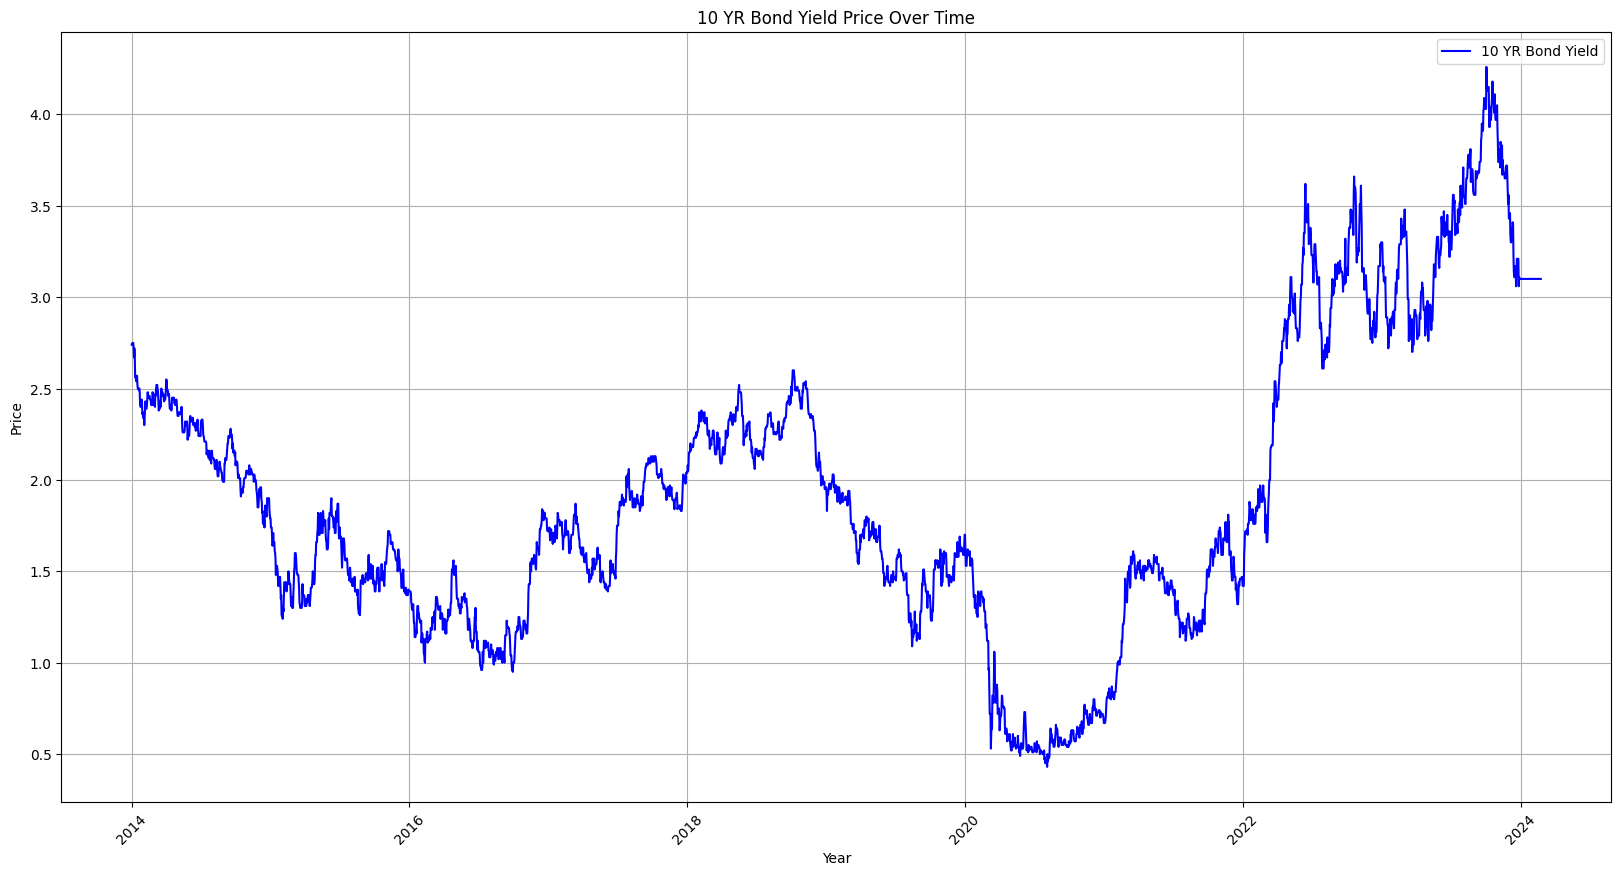

<Figure size 2000x1000 with 0 Axes>

In [79]:
for column in column_list:
    plot_line_chart(df.index,df[column], column)

## Correlation

In [19]:
# Correlation for all features
correlation_matrix = df.corr()
correlation_matrix

WTI Price  Natural Gas Price  Aluminum Price  Copper Price  \
WTI Price           1.000000           0.691857        0.656783      0.659518   
Natural Gas Price   0.691857           1.000000        0.564514      0.466107   
Aluminum Price      0.656783           0.564514        1.000000      0.901006   
Copper Price        0.659518           0.466107        0.901006      1.000000   
Gold Price          0.311235           0.180446        0.590163      0.748146   
Platinum Price      0.450357           0.199815        0.039261      0.183615   
Silver Price        0.407734           0.226986        0.595393      0.795114   
Lumber Price        0.331405           0.269039        0.721779      0.766871   
Interest_Rate       0.360792           0.040776        0.220869      0.317461   
GDP                 0.380167           0.260676        0.649146      0.654460   
CPI                 0.393975           0.264067        0.609268      0.686529   
HPI                 0.453035           0.396186        0.744171      0.786928   
Trade Balance       0.464029           0.377428        0.635766      0.640441   
Unemployment       -0.363410          -0.278795       -0.318505     -0.169848   
Wholesale Trade     0.354126           0.072845        0.474086      0.581013   
US_GDP              0.364459           0.240444        0.630747      0.695922   
Housing starts      0.152044           0.241085        0.518088      0.509500   
DAX                 0.273768           0.098656        0.684639      0.774960   
STOXX 50            0.387936           0.108095        0.660194      0.762661   
FTSE 100            0.475979           0.225774        0.569726      0.481513   
NASDAQ              0.300724           0.209669        0.700645      0.814699   
Nikkei 225          0.293209           0.154853        0.640914      0.750970   
Russell 2000        0.343772           0.260242        0.764480      0.842123   
S&P 500             0.361194           0.249253        0.734359      0.825760   
TSX                 0.532739           0.377059        0.832933      0.889819   
CADJPY              0.637287           0.443733        0.422223      0.494988   
EURCAD             -0.382128          -0.538158       -0.282881     -0.189152   
GBPCAD             -0.286727          -0.361213       -0.469853     -0.422764   
USDCAD             -0.506665          -0.308309       -0.114504     -0.172478   
10 YR Bond Yield    0.703438           0.417820        0.451575      0.456219   
Index Up           -0.009213          -0.002524       -0.000616      0.008243   
Year                0.232801           0.158398        0.606645      0.682733   
Month              -0.039453           0.127453       -0.031269     -0.049782   
Day                -0.007997          -0.000731       -0.001825     -0.004885   
DayofWeek           0.015554           0.001289        0.006826      0.011603   
EMA                 0.536196           0.385433        0.835878      0.887424   
RSI                 0.021109          -0.037093        0.019232      0.061534   

                   Gold Price  Platinum Price  Silver Price  Lumber Price  \
WTI Price            0.311235        0.450357      0.407734      0.331405   
Natural Gas Price    0.180446        0.199815      0.226986      0.269039   
Aluminum Price       0.590163        0.039261      0.595393      0.721779   
Copper Price         0.748146        0.183615      0.795114      0.766871   
Gold Price           1.000000       -0.120234      0.845721      0.642797   
Platinum Price      -0.120234        1.000000      0.292473      0.045550   
Silver Price         0.845721        0.292473      1.000000      0.713718   
Lumber Price         0.642797        0.045550      0.713718      1.000000   
Interest_Rate        0.470314       -0.174917      0.235821     -0.038345   
GDP                  0.715512       -0.396984      0.475768      0.484278   
CPI                  0.865588       -0.331083      0.604570      0.470742   
HPI             

In [20]:
# Correlation with just the target 
correlation_matrix['TSX']

WTI Price            0.532739
Natural Gas Price    0.377059
Aluminum Price       0.832933
Copper Price         0.889819
Gold Price           0.844693
Platinum Price      -0.102679
Silver Price         0.743057
Lumber Price         0.684443
Interest_Rate        0.504524
GDP                  0.843927
CPI                  0.875653
HPI                  0.923605
Trade Balance        0.817044
Unemployment        -0.280666
Wholesale Trade      0.748493
US_GDP               0.886501
Housing starts       0.617090
DAX                  0.914369
STOXX 50             0.874791
FTSE 100             0.615134
NASDAQ               0.921019
Nikkei 225           0.898234
Russell 2000         0.907011
S&P 500              0.955591
TSX                  1.000000
CADJPY               0.488912
EURCAD              -0.287032
GBPCAD              -0.570209
USDCAD               0.156101
10 YR Bond Yield     0.476547
Index Up             0.012437
Year                 0.869656
Month                0.025658
Day       

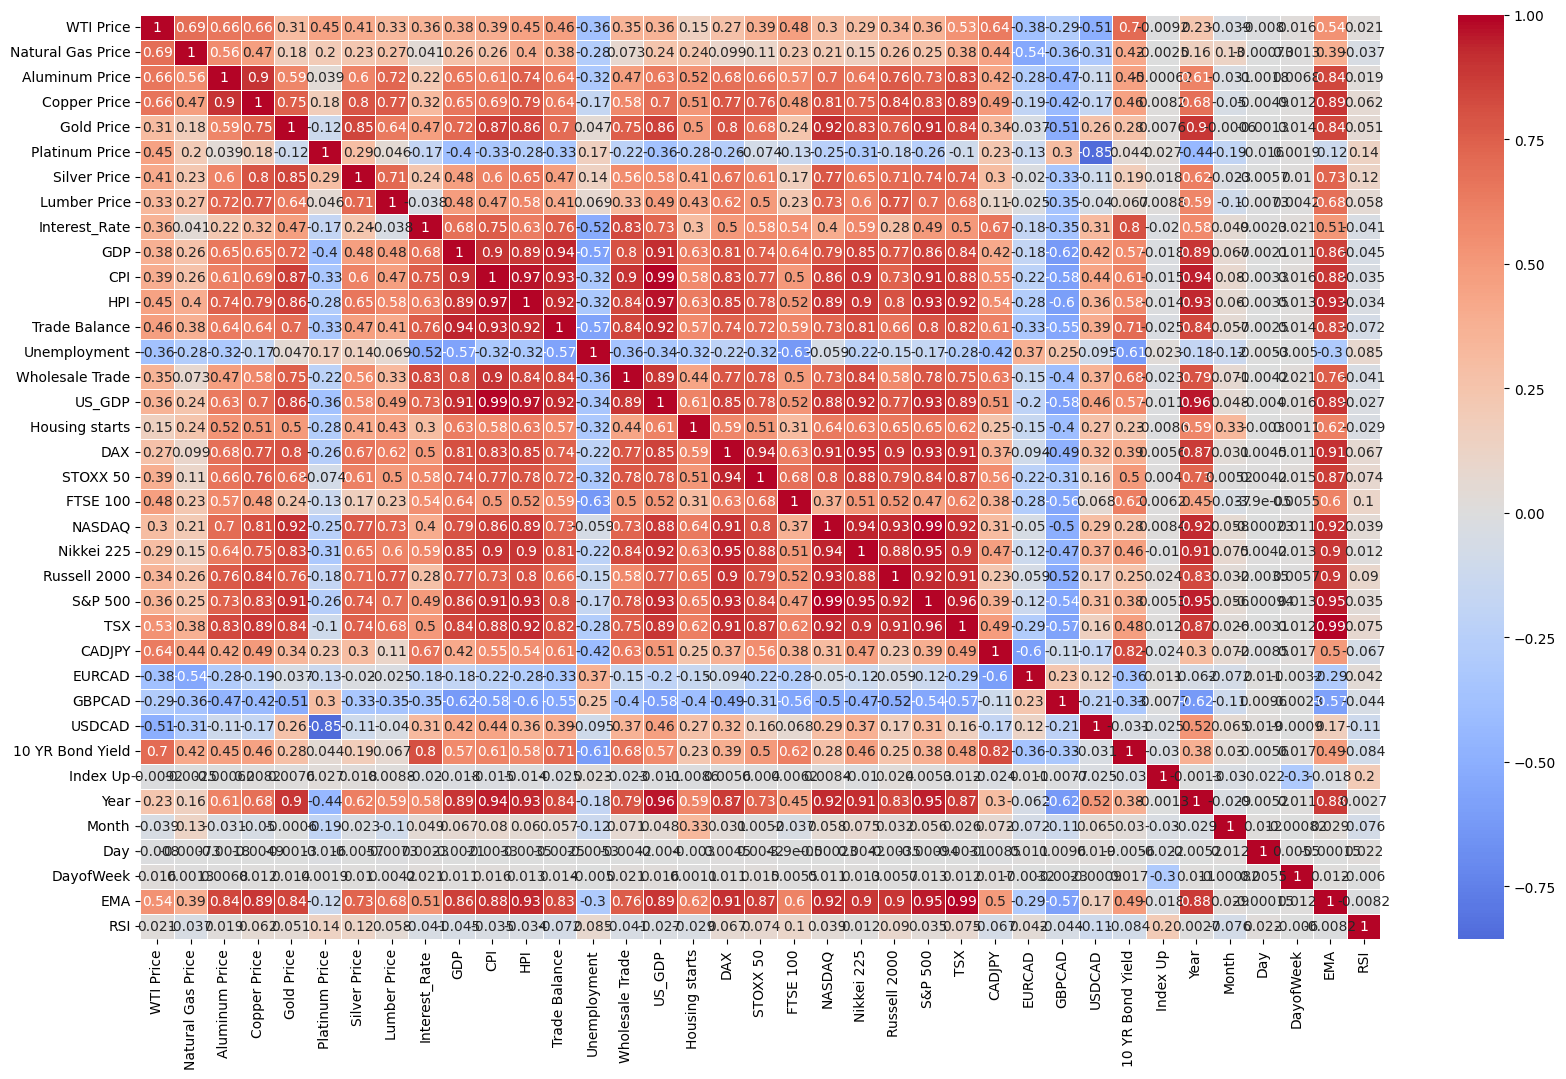

In [21]:
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.show()


In [26]:
# Identify upper triangle of the correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop those features with correlation greater than 0.9
# Although TSX has correlation greater than 0.9 it will not be dropped
to_drop.remove('EMA')
to_drop.remove('TSX')
df_reduced = df.drop(columns=to_drop)

# Print the results
print(f"Features dropped: {to_drop}")
print(f"Remaining features: {df_reduced.columns.tolist()}")
print(f"Number of features remaining: {df_reduced.shape[1]}")

Features dropped: ['Copper Price', 'CPI', 'HPI', 'Trade Balance', 'Wholesale Trade', 'US_GDP', 'STOXX 50', 'NASDAQ', 'Nikkei 225', 'Russell 2000', 'S&P 500', 'Year']
Remaining features: ['WTI Price', 'Natural Gas Price', 'Aluminum Price', 'Gold Price', 'Platinum Price', 'Silver Price', 'Lumber Price', 'Interest_Rate', 'GDP', 'Unemployment', 'Housing starts', 'DAX', 'FTSE 100', 'TSX', 'CADJPY', 'EURCAD', 'GBPCAD', 'USDCAD', '10 YR Bond Yield', 'Index Up', 'Month', 'Day', 'DayofWeek', 'EMA', 'RSI']
Number of features remaining: 25


## Principal Component Analysis

In [20]:
scaler = StandardScaler()
X = df.drop(['Index Up','TSX'],axis=1)
columns = X.columns
y = df['Index Up']
X = scaler.fit_transform(X)
dfx = pd.DataFrame(data=X, columns=columns)
dfx.head(10)

WTI Price  Natural Gas Price  Aluminum Price  Copper Price  Gold Price  \
0   1.698958           0.666773       -0.500262      0.351711   -0.925387   
1   1.538768           0.730270       -0.500262      0.351711   -0.925387   
2   1.466044           0.718142       -0.500262      0.313817   -0.881174   
3   1.466044           0.718142       -0.500262      0.313817   -0.881174   
4   1.466044           0.718142       -0.500262      0.313817   -0.881174   
5   1.440001           0.719568       -0.500262      0.320252   -0.883154   
6   1.451794           0.714574       -0.500262      0.320252   -0.910870   
7   1.385949           0.655358       -0.500262      0.295942   -0.924397   
8   1.353027           0.504819       -0.500262      0.233738   -0.911530   
9   1.405113           0.539065       -0.500262      0.294512   -0.853789   

   Platinum Price  Silver Price  Lumber Price  Interest_Rate       GDP  \
0        2.257198      0.217620     -0.540895      -0.298692 -1.551337   
1        2.410194      0.217620     -0.540895      -0.298692 -1.551337   
2        2.471695      0.239403     -0.526295      -0.298692 -1.551337   
3        2.471695      0.239403     -0.526295      -0.298692 -1.551337   
4        2.440490      0.239403     -0.526295      -0.298692 -1.551337   
5        2.490781      0.211059     -0.546318      -0.298692 -1.551337   
6        2.478966      0.128126     -0.537141      -0.298692 -1.551337   
7        2.497144      0.063040     -0.529632      -0.298692 -1.551337   
8        2.510777      0.100832     -0.490005      -0.298692 -1.551337   
9        2.622570      0.242553     -0.503771      -0.298692 -1.551337   

        CPI       HPI  Trade Balance  Unemployment  Wholesale Trade  US_GDP  \
0 -1.321182 -1.202502      -1.368568      0.629225        -0.942188 -1.3296   
1 -1.321182 -1.202502      -1.368568      0.629225        -0.942188 -1.3296   
2 -1.321182 -1.202502      -1.368568      0.629225        -0.942188 -1.3296   
3 -1.321182 -1.202502      -1.368568      0.629225        -0.942188 -1.3296   
4 -1.321182 -1.202502      -1.368568      0.629225        -0.942188 -1.3296   
5 -1.321182 -1.202502      -1.368568      0.629225        -0.942188 -1.3296   
6 -1.321182 -1.202502      -1.368568      0.629225        -0.942188 -1.3296   
7 -1.321182 -1.202502      -1.368568      0.629225        -0.942188 -1.3296   
8 -1.321182 -1.202502      -1.368568      0.629225        -0.942188 -1.3296   
9 -1.321182 -1.202502      -1.368568      0.629225        -0.942188 -1.3296   

   Housing starts       DAX  STOXX 50  FTSE 100    NASDAQ  Nikkei 225  \
0       -1.933145 -1.497835 -1.107282 -0.550803 -1.250372   -1.308464   
1       -1.933145 -1.497835 -1.107282 -0.550803 -1.250372   -1.308464   
2       -1.933145 -1.481114 -1.074129 -0.527035 -1.253434   -1.308464   
3       -1.933145 -1.481114 -1.074129 -0.527035 -1.253434   -1.308464   
4       -1.933145 -1.481114 -1.074129 -0.527035 -1.253434   -1.308464   
5       -1.933145 -1.484519 -1.086179 -0.526924 -1.258436   -1.308464   
6       -1.933145 -1.447278 -0.990607 -0.480878 -1.247598   -1.326455   
7       -1.933145 -1.451260 -0.991293 -0.543595 -1.244187   -1.268000   
8       -1.933145 -1.487563 -1.037935 -0.600295 -1.246772   -1.313899   
9       -1.933145 -1.462975 -1.006177 -0.509768 -1.241704   -1.307859   

   Russell 2000   S&P 500    CADJPY    EURCAD    GBPCAD    USDCAD  \
0     -1.183257 -1.302482  0.937549 -0.052006  0.228489 -2.987583   
1     -1.183257 -1.302482  0.860902 -0.139857  0.158441 -2.951553   
2     -1.167950 -1.303137  0.905795 -0.375851  0.068117 -2.999593   
3     -1.167950 -1.303137  0.905795 -0.375851  0.068117 -2.999593   
4     -1.167950 -1.303137  0.905795 -0.375851  0.068117 -2.999593   
5     -1.193405 -1.308082  0.820389 -0.255270  0.087473 -2.972904   
6     -1.163560 -1.296139  0.751408 -0.020999  0.250609 -2.824779   
7     -1.164044 -1.296559  0.721844  0.030678  0.376878 -2.754053   
8     -1.161507 -1.295871  0.698850  0.139200

In [21]:
pca = PCA(n_components=None)

dfx_pca = pca.fit(dfx)

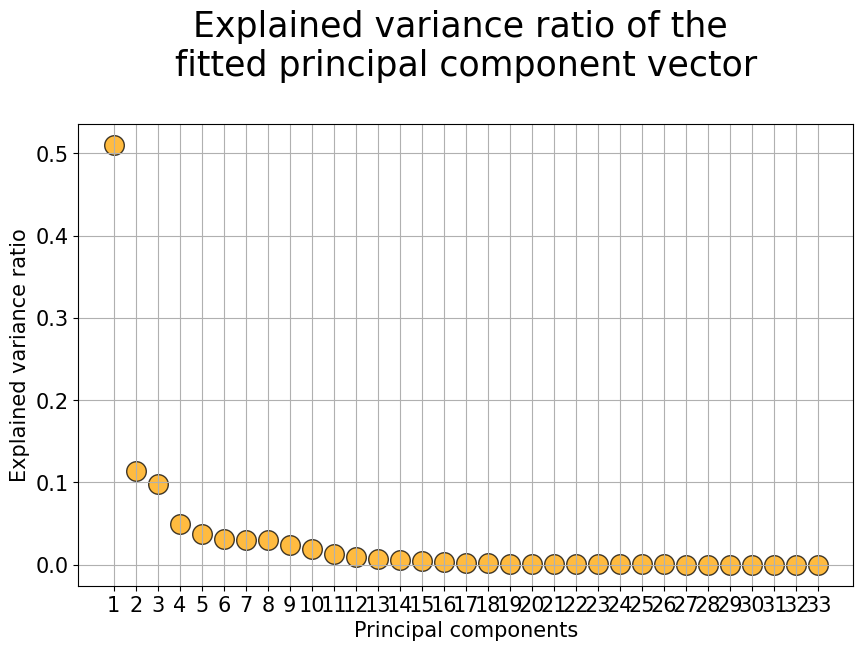

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],
            y=dfx_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [23]:
evr = pca.explained_variance_ratio_

In [24]:
evr

array([5.10378643e-01, 1.14335602e-01, 9.79267856e-02, 5.00537815e-02,
       3.71789087e-02, 3.11064990e-02, 3.03944780e-02, 3.00287017e-02,
       2.40621710e-02, 1.88457036e-02, 1.34770556e-02, 9.40294567e-03,
       7.48236207e-03, 5.33808478e-03, 4.71165162e-03, 3.69650054e-03,
       2.38374264e-03, 1.97502528e-03, 1.49391798e-03, 1.19665874e-03,
       9.24676443e-04, 7.52397926e-04, 6.88186432e-04, 6.04045601e-04,
       4.80136787e-04, 3.33293337e-04, 2.55791244e-04, 1.62316116e-04,
       1.27115196e-04, 9.23415920e-05, 4.86998781e-05, 3.70669886e-05,
       2.47129529e-05])

In [25]:
sorted_list = np.sort(evr)[::-1]

In [26]:
total_explained_variance = 0
total_pca_components = 0
for sorted in sorted_list:
    if sorted > 0.03:
        total_explained_variance = total_explained_variance + sorted
        total_pca_components = total_pca_components + 1
        print(sorted * 100)
print(f"Total PCA components is: {total_pca_components}")
print(f"Total Explained variance for select PCA is: {total_explained_variance}")

51.03786431392051
11.433560227972503
9.792678564338859
5.0053781501162495
3.7178908727813353
3.1106499006096864
3.039447797123634
3.0028701733474135
Total PCA components is: 8
Total Explained variance for select PCA is: 0.901403400002102


In [27]:
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(evr))],
    'Explained Variance Ratio': evr
})

# Display the DataFrame

print(explained_variance_df.sort_values(by='Explained Variance Ratio', ascending=False))

   Principal Component  Explained Variance Ratio
0                  PC1                  0.510379
1                  PC2                  0.114336
2                  PC3                  0.097927
3                  PC4                  0.050054
4                  PC5                  0.037179
5                  PC6                  0.031106
6                  PC7                  0.030394
7                  PC8                  0.030029
8                  PC9                  0.024062
9                 PC10                  0.018846
10                PC11                  0.013477
11                PC12                  0.009403
12                PC13                  0.007482
13                PC14                  0.005338
14                PC15                  0.004712
15                PC16                  0.003697
16                PC17                  0.002384
17                PC18                  0.001975
18                PC19                  0.001494
19                PC

In [28]:
# Get the components and feature names
pca_components = pca.components_
feature_names = columns

# Create a DataFrame for the PCA components
pca_df = pd.DataFrame(pca_components, columns=feature_names)

# View the top contributing features for the first PCA component
top_features_component_1 = pca_df.iloc[0].sort_values(ascending=False)
print("Top contributing features for the first component:")
print(top_features_component_1)

Top contributing features for the first component:
HPI                  0.237124
US_GDP               0.233868
S&P 500              0.233610
CPI                  0.232705
Nikkei 225           0.229562
Year                 0.225019
GDP                  0.224231
DAX                  0.222946
NASDAQ               0.222722
Trade Balance        0.222446
Russell 2000         0.210806
STOXX 50             0.210084
Wholesale Trade      0.208747
Gold Price           0.208067
Copper Price         0.203686
Aluminum Price       0.188524
Silver Price         0.167650
Interest_Rate        0.158550
Housing starts       0.158310
Lumber Price         0.151572
FTSE 100             0.150162
10 YR Bond Yield     0.145856
CADJPY               0.135048
WTI Price            0.120681
Natural Gas Price    0.083681
USDCAD               0.067596
Month                0.014143
DayofWeek            0.003740
Day                 -0.000619
Platinum Price      -0.053792
EURCAD              -0.059998
Unemployment       

In [29]:
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(pca.components_))], index=feature_names)

# Sum the absolute loadings for each feature across all principal components
importance = loadings.abs().sum(axis=1)

# Sort the features by their importance
sorted_importance = importance.sort_values(ascending=False)

# Display sorted importance
print(sorted_importance)

STOXX 50             4.793473
DAX                  4.725821
Gold Price           4.643223
GDP                  4.595419
FTSE 100             4.522711
Unemployment         4.476983
Platinum Price       4.443871
CADJPY               4.439761
Silver Price         4.378481
10 YR Bond Yield     4.336887
Interest_Rate        4.317836
Russell 2000         4.300751
Trade Balance        4.293835
Copper Price         4.223542
USDCAD               4.201760
Wholesale Trade      4.160466
Nikkei 225           4.159836
Natural Gas Price    4.120451
Aluminum Price       4.092041
GBPCAD               4.087322
US_GDP               4.075249
EURCAD               4.058810
WTI Price            4.035919
HPI                  4.033194
NASDAQ               3.618685
Housing starts       3.579291
Year                 3.563763
Lumber Price         3.539652
Month                3.437980
S&P 500              3.419217
CPI                  3.374089
Day                  1.822206
DayofWeek            1.563003
dtype: flo

## Exponential Moving Average
<p>An Exponential Moving Average (EMA) is a type of moving average that places a greater weight and significance on the most recent data points. It is commonly used in time series analysis, especially in financial markets, to smooth out data and identify trends more effectively than a simple moving average (SMA).</p>

In [15]:
n = 20 # period for the EMA. Used to track the trend of a stock over approximately one month, which is inline with other economic features.

df['EMA'] = df['TSX'].ewm(span=n, adjust=False).mean()
df.head()

WTI Price  Natural Gas Price  Aluminum Price  Copper Price  \
Date                                                                     
2014-01-01      98.70              4.232         1840.25        3.3815   
2014-01-02      95.44              4.321         1840.25        3.3815   
2014-01-03      93.96              4.304         1840.25        3.3550   
2014-01-04      93.96              4.304         1840.25        3.3550   
2014-01-05      93.96              4.304         1840.25        3.3550   

            Gold Price  Platinum Price  Silver Price  Lumber Price  \
Date                                                                 
2014-01-01      1225.2         1377.05        20.128         353.3   
2014-01-02      1225.2         1402.30        20.128         353.3   
2014-01-03      1238.6         1412.45        20.211         356.8   
2014-01-04      1238.6         1412.45        20.211         356.8   
2014-01-05      1238.6         1407.30        20.211         356.8   

            Interest_Rate        GDP    CPI   HPI  Trade Balance  \
Date                                                               
2014-01-01            1.0  1863035.0  123.1  94.1        41334.2   
2014-01-02            1.0  1863035.0  123.1  94.1        41334.2   
2014-01-03            1.0  1863035.0  123.1  94.1        41334.2   
2014-01-04            1.0  1863035.0  123.1  94.1        41334.2   
2014-01-05            1.0  1863035.0  123.1  94.1        41334.2   

            Unemployment  Wholesale Trade        US_GDP  Housing starts  \
Date                                                                      
2014-01-01           7.7       50184932.0  1.719202e+13         33923.0   
2014-01-02           7.7       50184932.0  1.719202e+13         33923.0   
2014-01-03           7.7       50184932.0  1.719202e+13         33923.0   
2014-01-04           7.7       50184932.0  1.719202e+13         33923.0   
2014-01-05           7.7       50184932.0  1.719202e+13         33923.0   

                DAX  STOXX 50  FTSE 100   NASDAQ  Nikkei 225  Russell 2000  \
Date                                                                         
2014-01-01  9400.04   3059.93   6717.91  4143.07    15908.88       1150.72   
2014-01-02  9400.04   3059.93   6717.91  4143.07    15908.88       1150.72   
2014-01-03  9435.15   3074.43   6730.67  4131.91    15908.88       1156.09   
2014-01-04  9435.15   3074.43   6730.67  4131.91    15908.88       1156.09   
2014-01-05  9435.15   3074.43   6730.67  4131.91    15908.88       1156.09   

            S&P 500       TSX  CADJPY  EURCAD  GBPCAD  USDCAD  \
Date                                                            
2014-01-01  1831.98  13594.19   98.88  1.4640  1.7634  1.0644   
2014-01-02  1831.98  13594.19   98.18  1.4589  1.7558  1.0671   
2014-01-03  1831.37  13548.86   98.59  1.4452  1.7460  1.0635   
2014-01-04  1831.37  13548.86   98.59  1.4452  1.7460  1.0635   
2014-01-05  1831.37  13548.86   98.59  1.4452  1.7460  1.0635   

            10 YR Bond Yield  Index Up  Year  Month  Day  DayofWeek  \
Date                                                                  
2014-01-01              2.74     False  2014      1    1          2   
2014-01-02              2.74     False  2014      1    2          3   
2014-01-03              2.75     False  2014      1    3          4   
2014-01-04              2.75     False  2014      1    4          5   
2014-01-05              2.75     False  2014      1    5          6   

                     EMA  
Date                      
2014-01-01  13594.190000  
2014-01-02  13594.190000  
2014-01-03  13589.872857  
2014-01-04  13585.966871  
2014-01-05  13582.432883

## Relative Strength Index
<p>The Relative Strength Index (RSI) is a momentum oscillator used in technical analysis that measures the speed and change of price movements. It is typically used to identify overbought or oversold conditions in a market. The RSI oscillates between 0 and 100, making it easy to interpret and apply in various trading strategies.</p>
<p>Below 30: The asset is generally considered oversold, indicating that it may be undervalued and due for a rebound. </p>
<p>Above 70: The asset is generally considered overbought, indicating that it may be overvalued and due for a correction or pullback.</p>

In [16]:
df['RSI'] = calculate_rsi(df['TSX'])

## Volatility
<p>Understanding the price fluctuations of a financial asset and measuring the risk associated with the asset on a daily basis.</p>

In [32]:
# Calculate Daily Returns
df['Daily Return'] = df['TSX'].pct_change()  # Simple returns

# Calculate the Rolling Standard Deviation of Daily Returns
df['Daily Volatility'] = df['Daily Return'].rolling(window=14).std()

df = df.drop(columns=['Daily Return']).head(30)

In [15]:
print(df[['TSX','Daily Volatility']].tail())

                 TSX  Daily Volatility
Date                                  
2024-02-19  21255.61          0.009387
2024-02-20  21217.53          0.008907
2024-02-21  21172.38          0.008907
2024-02-22  21318.08          0.009055
2024-02-23  21413.15          0.009031


In [36]:
# Fill all NaN values with zero for EMA, RSI and Volatility
df_reduced = df_reduced.fillna(0)

In [28]:
df.tail()

WTI Price  Natural Gas Price  Aluminum Price  Copper Price  \
Date                                                                     
2024-02-19      78.11              1.558          2197.0        3.8110   
2024-02-20      78.18              1.576          2193.5        3.8675   
2024-02-21      77.91              1.773          2219.5        3.8750   
2024-02-22      78.61              1.732          2198.0        3.8970   
2024-02-23      76.49              1.603          2180.0        3.8800   

            Gold Price  Platinum Price  Silver Price  Lumber Price  \
Date                                                                 
2024-02-19      2027.5          905.65        23.003         565.0   
2024-02-20      2039.8          914.30        23.136         556.5   
2024-02-21      2034.3          889.60        22.874         560.5   
2024-02-22      2030.7          905.50        22.784         564.5   
2024-02-23      2049.4          909.60        22.982         564.5   

            Interest_Rate        GDP    CPI    HPI  Trade Balance  \
Date                                                                
2024-02-19            5.0  2215040.0  158.3  124.3        62379.9   
2024-02-20            5.0  2215040.0  158.3  124.3        62379.9   
2024-02-21            5.0  2215040.0  158.3  124.3        62379.9   
2024-02-22            5.0  2215040.0  158.3  124.3        62379.9   
2024-02-23            5.0  2215040.0  158.3  124.3        62379.9   

            Unemployment  Wholesale Trade        US_GDP  Housing starts  \
Date                                                                      
2024-02-19           6.1      117287179.0  2.795700e+13         62696.0   
2024-02-20           6.1      117287179.0  2.795700e+13         62696.0   
2024-02-21           6.1      117287179.0  2.795700e+13         62696.0   
2024-02-22           6.1      117287179.0  2.795700e+13         62696.0   
2024-02-23           6.1      117287179.0  2.795700e+13         62696.0   

                 DAX  STOXX 50  FTSE 100    NASDAQ  Nikkei 225  Russell 2000  \
Date                                                                           
2024-02-19  17092.26   4763.07   7728.50  15775.65    38470.38       2032.74   
2024-02-20  17068.43   4760.28   7719.21  15630.78    38363.61       2004.14   
2024-02-21  17118.12   4775.31   7662.51  15580.87    38262.16       1994.74   
2024-02-22  17370.45   4855.36   7684.49  16041.62    39098.68       2013.84   
2024-02-23  17419.33   4872.57   7706.28  15996.82    39098.68       2016.69   

            S&P 500       TSX  CADJPY  EURCAD  GBPCAD  USDCAD  \
Date                                                            
2024-02-19  5005.57  21255.61  111.27  1.4536  1.6985  1.3488   
2024-02-20  4975.51  21217.53  110.89  1.4606  1.7060  1.3520   
2024-02-21  4981.80  21172.38  111.27  1.4608  1.7062  1.3505   
2024-02-22  5087.03  21318.08  111.64  1.4590  1.7066  1.3481   
2024-02-23  5088.80  21413.15  111.42  1.4610  1.7112  1.3505   

            10 YR Bond Yield  Index Up  Year  Month  Day  DayofWeek  \
Date                                                                  
2024-02-19               3.1     False  2024      2   19          0   
2024-02-20               3.1     False  2024      2   20          1   
2024-02-21               3.1     False  2024      2   21          2   
2024-02-22               3.1      True  2024      2   22          3   
2024-02-23               3.1      True  2024      2   23          4   

                     EMA        RSI  
Date                                 
2024-02-19  21078.285441  55.134103  
2024-02-20  21091.546828  61.633480  
2024-02-21  21099.245225  57.427812  
2024-02-22  21120.086632  61.047432  
2024-02-23  21147.997429  65.188381

In [42]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3226 entries, 2014-01-01 to 2024-02-23
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   WTI Price          3226 non-null   float64
 1   Natural Gas Price  3226 non-null   float64
 2   Aluminum Price     3226 non-null   float64
 3   Gold Price         3226 non-null   float64
 4   Platinum Price     3226 non-null   float64
 5   Silver Price       3226 non-null   float64
 6   Lumber Price       3226 non-null   float64
 7   Interest_Rate      3226 non-null   float64
 8   GDP                3226 non-null   float64
 9   Unemployment       3226 non-null   float64
 10  Housing starts     3226 non-null   float64
 11  DAX                3226 non-null   float64
 12  FTSE 100           3226 non-null   float64
 13  TSX                3226 non-null   float64
 14  CADJPY             3226 non-null   float64
 15  EURCAD             3226 non-null   float64
 16  GBPCAD

## Time-Series-Split Data for Time Series Data Set

In [38]:
X = df_reduced.drop(columns=['Index Up'])
y = df_reduced['Index Up']

In [39]:
tss = TimeSeriesSplit(n_splits=3)

In [40]:
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [41]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) # maintain column names
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [43]:
X_train_scaled.to_csv('../data/processed/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test_scaled.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)